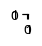

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

In [2]:
total_exp=pd.read_csv(f'../output/TCRBASE/total_mean_exp_results.csv', index_col=0)
total_old=pd.read_csv(f'../output/TCRBASE/total_mean_old_results.csv', index_col=0)
exp_filt = total_exp.query('n_pos>=75').sort_values('auc',ascending=False).head(17).index
total_exp.query('n_pos>75').sort_values('auc',ascending=False).head(17).sort_index()

,n_pos,auc,auc_01,auc_01_real,precision,recall,accuracy,AP,partition
peptide,,,,,,,,,
AVFDRKSDAK,143.4,0.537760,0.523512,0.094672,0.166668,1.0,0.166668,0.216992,2.0
ELAGIGILTV,91.4,0.913552,0.809742,0.638514,0.166668,1.0,0.166668,0.782364,2.0
GILGFVFTL,233.0,0.829168,0.744974,0.515450,0.166670,1.0,0.166670,0.634484,2.0
KLGGALQAK,180.2,0.583082,0.561664,0.167164,0.166664,1.0,0.166664,0.289294,2.0
RAKFKQLL,166.0,0.901230,0.833696,0.684024,0.166670,1.0,0.166670,0.779796,2.0
SPRWYFYYL,89.8,0.671422,0.649950,0.334904,0.166670,1.0,0.166670,0.475666,2.0
TTDPSFLGRY,77.4,0.672200,0.632344,0.301454,0.166666,1.0,0.166666,0.458376,2.0
YLQPRTFLL,79.8,0.731442,0.694864,0.420246,0.166662,1.0,0.166662,0.573052,2.0


In [408]:
# Random test here : 
dm_tbcr = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_cdr3_distmatrix_26peps_labeled.csv', index_col=0).drop(columns=['q_index'])
dm_tbcr = dm_tbcr.query('partition==0').sample(frac=0.1)
fake = dm_tbcr[[str(c) for c in dm_tbcr.index]+['peptide','original_peptide','partition','original_index']]

In [456]:
from src.cluster_utils import cluster_single_threshold
values_array = fake.iloc[:len(fake),:len(fake)].values
labels = fake['peptide'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# best_agglo = cluster_test.loc[cluster_test['silhouette'].idxmax()]
best_res, df, c = cluster_single_threshold(values_array, values_array, labels, encoded_labels, label_encoder, 
                         threshold=0.16, return_df_and_c = True)

In [457]:
display(fake.head(3))
display(df.head(3))

,1003,3597,3737,2121,3337,347,227,5544,2614,2003,...,6334,4101,3569,2277,5224,76,peptide,original_peptide,partition,original_index
1003,0.000000,0.229725,0.176168,0.212460,0.189374,0.205211,0.215002,0.220142,0.178056,0.200648,...,0.212322,0.194862,0.183500,0.157436,0.227383,0.203178,DATYQRTRALVR,DATYQRTRALVR,0,4169
3597,0.229725,0.000000,0.199345,0.208820,0.229313,0.207357,0.220732,0.249424,0.191146,0.225181,...,0.244403,0.185122,0.234229,0.187361,0.210473,0.240978,KLGGALQAK,KLGGALQAK,0,659
3737,0.176168,0.199345,0.000000,0.196315,0.180140,0.164076,0.170639,0.230425,0.150677,0.203043,...,0.133928,0.183892,0.209133,0.120986,0.228740,0.172448,AVFDRKSDAK,AVFDRKSDAK,0,5508


,pred_label,purity,coherence,cluster_size,majority_label
0,0,0.5,0.157551,2,ELAGIGILTV
1,1,0.5,0.151117,2,AVFDRKSDAK
2,2,1.0,0.120294,5,GILGFVFTL


In [480]:
subset = get_agglo_cluster_df(c, fake, 'original_index', 'peptide', ('peptide','original_peptide','partition','original_index'))
subset.sort_values('pred_label')

['original_index', 'peptide', 'original_peptide', 'partition']


,original_index,peptide,original_peptide,partition,pred_label,purity,cluster_size,majority_label
41,1405,ELAGIGILTV,ELAGIGILTV,0,0,0.5,2.0,ELAGIGILTV
5,2375,SPRWYFYYL,SPRWYFYYL,0,0,0.5,2.0,SPRWYFYYL
116,1138,RAKFKQLL,RAKFKQLL,0,1,0.5,2.0,RAKFKQLL
95,1546,AVFDRKSDAK,AVFDRKSDAK,0,1,0.5,2.0,AVFDRKSDAK
91,284,GILGFVFTL,GILGFVFTL,0,2,1.0,5.0,GILGFVFTL
...,...,...,...,...,...,...,...,...
93,2285,AVFDRKSDAK,AVFDRKSDAK,0,88,NaN,1.0,AVFDRKSDAK
44,1098,KLGGALQAK,KLGGALQAK,0,89,NaN,1.0,KLGGALQAK
11,2141,AVFDRKSDAK,AVFDRKSDAK,0,90,NaN,1.0,AVFDRKSDAK
9,2179,RFPLTFGWCF,RFPLTFGWCF,0,91,NaN,1.0,RFPLTFGWCF


In [418]:
df.cluster_size.sum()

58

In [414]:
best_res

{'threshold': 0.16,
 'n_cluster': 24,
 'n_singletons': 69,
 'n_cluster_over_70p': 9,
 'mean_purity': 0.6930555555555555,
 'min_purity': 0.5,
 'max_purity': 1.0,
 'mean_coherence': 0.13050212013888884,
 'min_coherence': 0.078254,
 'max_coherence': 0.157551,
 'mean_cluster_size': 2.4166666666666665,
 'min_cluster_size': 2,
 'max_cluster_size': 5,
 'silhouette': 0.0870880201489934,
 'ch_index': 4.462156430414442,
 'db_index': 0.6463946966576696,
 'ARI': 0.04856109203364346}

# inits

In [2]:
def get_agg_matrix(dm_vae, dm_base, index_col='raw_index', cols = ('peptide', 'original_peptide','raw_index', 'binder', 'partition')):
    if not all([x==y for x,y in zip(dm_vae[index_col].values, dm_base[index_col].values)]):
        dm_base, values_base = resort_baseline(dm_base, dm_vae, index_col)
    else:
        values_base = None
    values_vae = dm_vae.iloc[:len(dm_vae), :len(dm_vae)].values
    if values_base is None:
        values_base = dm_base.iloc[:len(dm_base), :len(dm_base)].values
    assert all([x==y for x,y in zip(dm_vae[index_col].values, dm_base[index_col].values)]) and len(dm_vae)==len(dm_base)
    agg_values = 1-np.multiply(1-values_vae, 1-values_base)
    agg_dm = pd.DataFrame(agg_values)
    agg_dm[list(cols)] = dm_vae[list(cols)].values
    return agg_dm, agg_dm.iloc[:len(agg_dm), :len(agg_dm)].values

def plot_prune_heatmap(values, threshold, title, 
                       filename=None, outdir='../output/240618_NestedKCV_CNNVAE/notebook_figs/',
                       sorted_dm=None,
                       cmap='icefire', color='g', addline=True):
    # prune and plot the heatmap
    f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
    ax = ax.ravel()
    ax, cbar_ax = ax[0], ax[1]
    pruned = values.copy()
    mask = (pruned<=threshold).astype(int)
    pruned = pruned * mask
    sns.heatmap(pruned, ax=ax, square=True, vmin=0, vmax=threshold, cbar_ax=cbar_ax, cmap=cmap)
    # Set up custom tickmarks if available
    if sorted_dm is not None:
        pepmap = sorted_dm.groupby('peptide').agg(count=('raw_index','count'))
        pepmap['idx']=pepmap['count'].cumsum()
        pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
        tickmarks = pepmap['tick'].to_dict() 
        idxs = pepmap['idx'].to_dict()
        ax.set_xticks(list(tickmarks.values()))
        ax.set_yticks(list(tickmarks.values()))
        ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
        ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
    if addline and sorted_dm is not None:
        for k,v in idxs.items():
            ax.axhline(v, ls='--', lw=.9, c=color)
            ax.axvline(v, ls='--', lw=.9, c=color)
    # Rotate the tick labels for better readability (optional)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title(title, fontweight='semibold', fontsize=17)
    f.tight_layout()
    if filename is not None:
        f.savefig(f'{outdir}heatmaps/{filename}.png', dpi=150, bbox_inches='tight')
    

In [3]:
model_ts128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/epoch_5000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj_JSON_kwargs.json',
                              map_location='cpu', verbose=False)
# model_os128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ.pt',
#                               '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ_JSON_kwargs.json',
#                               map_location='cpu', verbose=False)
# model_os256 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/epoch_8000_interval_checkpoint__fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02.pt',
#                               '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02_JSON_kwargs.json',
#                               map_location='cpu', verbose=False)

# model_ts128_notrp = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm/epoch_4000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm.pt',
#                                     '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm_JSON_kwargs.json',
#                                     map_location='cpu', verbose=False)
# model_os128_notrp = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni.pt',
#                                     '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni_JSON_kwargs.json',
#                               map_location='cpu', verbose=False)

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()


# Try on some random downloaded repertoire data

## metadata parsing

In [4]:
import csv
def get_metadata(filename):
    # Initialize a dictionary to hold the header information
    metadatares = {'filename':os.path.basename(filename)}
    metadatares['relpath']=filename
    # Read the CSV file
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Read the first line which contains the metadata
        metadata_line = next(reader)[0]
        # Convert the metadata line to a dictionary
        metadata = eval(metadata_line)
    metadatares.update(metadata)
    return metadatares
    
def read_ots_data(filename):
    metadata = get_metadata(filename)
    df = pd.read_csv(filename, skiprows=1)
    df = df[[c for c in df.columns if ('aa' in c.lower() and 'cdr' in c.lower()) or 'call' in c.lower()]]
    df.columns = [x.replace('cdr','').replace('_aa_','').replace('beta','B').replace('alpha','A')[::-1] if 'cdr' in x else x for x in df.columns]
    df.columns = df.columns.str.replace('_call','')
    df['Link']=metadata['Link']
    df['Disease']=metadata['Disease']
    df['CancerType']=metadata['CancerType']
    df['Source']=metadata['TSource']
    df['Subject']=metadata['Subject']
    return df, metadata


def plot_prune_heatmap(values, threshold, title, 
                       filename=None, outdir='../output/240618_NestedKCV_CNNVAE/notebook_figs/',
                       sorted_dm=None,
                       cmap='vlag', color='g', addline=True):
    # prune and plot the heatmap
    f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
    ax = ax.ravel()
    ax, cbar_ax = ax[0], ax[1]
    pruned = values.copy()
    mask = (pruned<=threshold).astype(int)
    pruned = pruned * mask
    sns.heatmap(pruned, ax=ax, square=True, vmin=0, vmax=values.max(), cbar_ax=cbar_ax, cmap=cmap)
    # Set up custom tickmarks if available
    if sorted_dm is not None:
        pepmap = sorted_dm.groupby('peptide').agg(count=('raw_index','count'))
        pepmap['idx']=pepmap['count'].cumsum()
        pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
        tickmarks = pepmap['tick'].to_dict() 
        idxs = pepmap['idx'].to_dict()
        ax.set_xticks(list(tickmarks.values()))
        ax.set_yticks(list(tickmarks.values()))
        ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
        ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
    if addline and sorted_dm is not None:
        for k,v in idxs.items():
            ax.axhline(v, ls='--', lw=.9, c=color)
            ax.axvline(v, ls='--', lw=.9, c=color)
    # Rotate the tick labels for better readability (optional)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title(title, fontweight='semibold', fontsize=17)
    f.tight_layout()
    if filename is not None:
        f.savefig(f'{outdir}{filename}.png', dpi=150, bbox_inches='tight')
    plt.close()
    del f, ax

def do_all(filename, model, noplot=False, unique=False, outdir='../output/240820_HumanRepertoires/'):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    if unique:
        df.drop_duplicates(subset=['tcr'], inplace=True)
    metadata['n_seq'] = len(df)
    metadata['n_unique'] = len(df['tcr'].unique())
    pd.DataFrame(metadata, index=[0]).to_csv(f"{outdir}metadata/{metadata['Run']}_metadata.txt", index=False)
    if noplot:
        return 0
    else:
            
        if len(glob.glob(f'{outdir}heatmaps/*{metadata["Run"]}*'))>0:
            return 0
    
        latent_df = get_latent_df(model, df)
        latent_df['index_col'] = [f'seq_{i:04}' for i in range(len(latent_df))]
        _, values_array, _, _, _, _ = get_distances_labels_from_latent(latent_df, 
                                                                       label_col='Disease', 
                                                                       index_col='index_col',
                                                                       rest_cols=['Disease','CancerType','Source'],
                                                                       low_memory=True)
        
        latent_df['tcr'] = latent_df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
        n_seq=len(latent_df)
        n_unique=len(latent_df['tcr'].unique())
        plot_prune_heatmap(values_array, threshold=10, title=f"{metadata['Run']}, n_seq={n_seq}, n_unique={n_unique}", 
                           filename=f'{metadata["Run"]}_n-{n_seq}_unique-{n_unique}',
                           outdir=f'{outdir}heatmaps/', addline=False, sorted_dm=None)
        print(metadata['Run'], '\t', n_seq, '\t', n_unique)
        del latent_df
    # latent_df.groupby(['tcr']).agg(count=('B1','count')).sort_values('count',ascending=False)

## init

In [949]:
meta_df = pd.read_csv('../data/OTS/human/METADATA.txt')
meta_df.groupby(['Link','Author']).agg(disease=('Disease','unique'),
                                      n_repertoires=('Disease','count'),
                                      mean_size=('Sequences', 'mean'),
                                      mean_unique=('n_unique','mean'))

,,disease,n_repertoires,mean_size,mean_unique
Link,Author,,,,
https://pubmed.ncbi.nlm.nih.gov/33478949/,Kusnadi et al. 2021,[covid],15,4657.133333,734.266667
https://pubmed.ncbi.nlm.nih.gov/34156975/,"Peng et al., 2021",[herpes_simplex_virus_type_2],4,1324.250000,681.250000
https://pubmed.ncbi.nlm.nih.gov/34793243/,Francis et al. 2021,[covid],95,1655.589474,821.357895
https://pubmed.ncbi.nlm.nih.gov/36516854/,Yu et al. 2022,[cmv],6,2545.833333,733.500000
https://pubmed.ncbi.nlm.nih.gov/37580605/,Garner et al.,[healthy],96,5587.364583,1663.104167
https://www.nature.com/articles/s41590-022-01367-z,Xu et al. 2023,[covid],8,4370.750000,3346.875000
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10201342/,Eberhardt et al. 2021,[cancer],51,1234.333333,191.705882


In [952]:
meta_df.query('Disease=="cancer"').Author.unique()

array(['Eberhardt et al. 2021'], dtype=object)

# Sample run

In [6]:
df, metadata = read_ots_data('../data/SRR15178288_1_Paired_All.csv')
df.sort_values('B3')

,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,A1,A2,A3,Link,Disease,CancerType,Source,Subject
1384,TRBV19*01,TRBD1*01,TRBJ1-3*01,LNHDA,SQIVND,ASFNRVGGNTIY,TRAV17*01,NaN,TRAJ37*02,TSINN,IRSNERE,ASHSSNTGKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
1303,TRBV11-2*01,TRBD1*01,TRBJ1-1*01,SGHAT,FQNNGV,ASNEGTYTEAF,TRAV19*01,NaN,TRAJ23*01,TRDTTYY,RNSFDEQN,ALSLGGKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
1203,TRBV11-2*01,TRBD1*01,TRBJ1-1*01,SGHAT,FQNNGV,ASNEGTYTEAF,TRAV19*01,NaN,TRAJ23*01,TRDTTYY,RNSFDEQN,ALSLGGKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
1739,TRBV11-2*01,TRBD1*01,TRBJ1-1*01,SGHAT,FQNNGV,ASNEGTYTEAF,TRAV19*01,NaN,TRAJ23*01,TRDTTYY,RNSFDEQN,ALSLGGKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
862,TRBV11-2*01,TRBD1*01,TRBJ1-1*01,SGHAT,FQNNGV,ASNEGTYTEAF,TRAV19*01,NaN,TRAJ23*01,TRDTTYY,RNSFDEQN,ALSLGGKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1810,TRBV20-1*01,TRBD2*01,TRBJ2-2*01,DFQATT,SNEGSKA,SARPTPGGGLPDTGELF,TRAV21*01,NaN,TRAJ32*02,DSAIYN,IQSSQRE,AVLGGATNKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
1278,TRBV20-1*01,TRBD2*01,TRBJ2-2*01,DFQATT,SNEGSKA,SARPTPGGGLPDTGELF,TRAV21*01,NaN,TRAJ32*02,DSAIYN,IQSSQRE,AVLGGATNKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
587,TRBV20-1*01,TRBD2*01,TRBJ2-2*01,DFQATT,SNEGSKA,SARPTPGGGLPDTGELF,TRAV21*01,NaN,TRAJ32*02,DSAIYN,IQSSQRE,AVLGGATNKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
982,TRBV20-1*01,TRBD2*01,TRBJ2-2*01,DFQATT,SNEGSKA,SARPTPGGGLPDTGELF,TRAV26-1*02,NaN,TRAJ52*01,TISGNEY,GLKNN,IVRVSNAGGTSYGKLT,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7


In [7]:
df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
counts = df.groupby('tcr').agg(count=('B3','count'))
df = df.drop_duplicates(subset=['tcr'])
df = df.set_index('tcr').merge(counts,left_index=True,right_index=True).reset_index()
df

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,A1,A2,A3,Link,Disease,CancerType,Source,Subject,count
0,VSPFSNMTFSENTVVRGDYKLSMNHNSSASEGTASSEGGDRAYGYT,TRBV6-1*01,TRBD1*01,TRBJ1-2*01,MNHNS,SASEGT,ASSEGGDRAYGYT,TRAV10*01,NaN,TRAJ20*01,VSPFSN,MTFSENT,VVRGDYKLS,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,83
1,DSAIYNIQSSQREAADTGGFKTIMNHEYSMNVEVASTGGDYNSPLH,TRBV27*01,TRBD1*01,TRBJ1-6*02,MNHEY,SMNVEV,ASTGGDYNSPLH,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AADTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,165
2,TSINNIRSNEREATDEGGGQKLLSGHATFQNNGVASSLEAANYGYT,TRBV11-2*01,NaN,TRBJ1-2*01,SGHAT,FQNNGV,ASSLEAANYGYT,TRAV17*01,NaN,TRAJ16*01,TSINN,IRSNERE,ATDEGGGQKLL,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,6
3,DSAIYNIQSSQREAVDTGGFKTIMNHEYSVGAGIASSYSDGNYGYT,TRBV6-5*01,NaN,TRBJ1-2*01,MNHEY,SVGAGI,ASSYSDGNYGYT,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AVDTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,149
4,DSAIYNIQSSQREAVDTGGFKTIMNHEYSVGAGIASTRLSGDYGYT,TRBV6-5*01,TRBD2*01,TRBJ1-2*01,MNHEY,SVGAGI,ASTRLSGDYGYT,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AVDTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,95
5,DSAIYNIQSSQREAVDTGGFKTIMNHEYSMNVEVASTHGDRAGELF,TRBV27*01,TRBD1*01,TRBJ2-2*01,MNHEY,SMNVEV,ASTHGDRAGELF,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AVDTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,98
6,TRDTTYYRNSFDEQNALVKYSGAGSYQLTDFQATTSNEGSKASAQD...,TRBV20-1*02,TRBD1*01,TRBJ1-2*01,DFQATT,SNEGSKA,SAQDRVGYGYT,TRAV19*01,NaN,TRAJ28*01,TRDTTYY,RNSFDEQN,ALVKYSGAGSYQLT,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,41
7,YGATPYYFSGDTLVAVGDGGGSNYKLTLNHDASQIVNDASSFLGRR...,TRBV19*01,TRBD2*01,TRBJ2-1*01,LNHDA,SQIVND,ASSFLGRRGGGDEQF,TRAV8-3*01,NaN,TRAJ53*01,YGATPY,YFSGDTLV,AVGDGGGSNYKLT,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,61
8,DSAIYNIQSSQREAVDTGGFKTIMNHEYSMNVEVASTPGDGNYGYT,TRBV27*01,TRBD1*01,TRBJ1-2*01,MNHEY,SMNVEV,ASTPGDGNYGYT,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AVDTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,61
9,DSAIYNIQSSQREAADTGGFKTIMNHEYSMNVEVASSPADRGDGYT,TRBV27*01,TRBD1*01,TRBJ1-2*01,MNHEY,SMNVEV,ASSPADRGDGYT,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AADTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,73


In [88]:
def read_ots_unique(filename):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    metadata['n_seq'] = len(df)
    metadata['unique'] = len(df.tcr.unique())
    counts = df.groupby('tcr').agg(count=('B3','count'))
    df = df.drop_duplicates(subset=['tcr'])
    df = df.set_index('tcr').merge(counts,left_index=True,right_index=True).reset_index()
    df['Run']=metadata['Run']
    return df, metadata

In [481]:
df, metadata = read_ots_unique('../data/OTS/human/SRR12164411_1_Paired_All.csv')
latent_df = get_latent_df(model_ts128, df)
latent_df['index_col'] = [f'seq_{i:04}' for i in range(len(latent_df))]
latent_df = latent_df#.sample(frac=0.25)
dist_matrix, values_array, _, labels, encoded_labels, label_encoder = get_distances_labels_from_latent(latent_df, 
                                                                                                       label_col='Disease', 
                                                                                                       index_col='index_col',
                                                                                                       rest_cols=['Disease','CancerType','Source'])
display(dist_matrix['index_col'].head())
display(latent_df['index_col'].head())

VGISALSSGKAVSPGTDKLIMNHEYSMNVEVASSTGYGSNQPQH         seq_0000
SVFSSVVTGGEVAGEAGYGKLTLNHNVYYDKDFATSPLRGGWTEAF       seq_0001
NSASQSVYSSGNVVKTDSNYQLIMGHRAYSYEKLASSQDSTGNTEAF      seq_0002
SVFSSVVTGGEVAGCRYGNKLVMNHNSSASEGTASSGGTTDTQY         seq_0003
TSGFNGNVLDGLAVRGAGNQFYSGDLSYYNGEEASSGPLEGGAGVNEQF    seq_0004
Name: index_col, dtype: object

0    seq_0000
1    seq_0001
2    seq_0002
3    seq_0003
4    seq_0004
Name: index_col, dtype: object

### params

In [323]:
initial_cut_threshold=1
initial_cut_method='top'
filename=metadata['Run']

### Running the algos for baselines

In [482]:
# TBCRALIGN
G, original_tree, dist_matrix, values_array, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dist_matrix, label_col='Disease',
                                                                                                                   index_col='index_col', algorithm='kruskal')

# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, size_scores, size_purities, size_retentions = iterative_size_cut(values_array, original_tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, topn_scores, topn_purities, topn_retentions = iterative_topn_cut(values_array, original_tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))

here
Initial mean purity, silhouette score, retention
1.0 0.0264 1.0
2.1548387096774193 2.529032258064516


In [483]:
from src.cluster_utils import get_cut_cluster_df
topn_results = get_cut_cluster_df(original_tree, topn_clusters)
size_results = get_cut_cluster_df(original_tree, size_clusters)

In [485]:
topn_results

,node,label,index,pred_label,cluster_size,majority_label,purity
0,66,covid,seq_0066,0,4,covid,1.0
1,167,covid,seq_0167,0,4,covid,1.0
2,187,covid,seq_0187,0,4,covid,1.0
3,222,covid,seq_0222,0,4,covid,1.0
4,0,covid,seq_0000,1,3,covid,1.0
...,...,...,...,...,...,...,...
412,409,covid,seq_0409,233,1,covid,NaN
413,413,covid,seq_0413,234,1,covid,NaN
414,414,covid,seq_0414,235,1,covid,NaN
415,415,covid,seq_0415,236,1,covid,NaN


In [364]:
cluster_test

,threshold,n_cluster,n_singletons,n_cluster_over_70p,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,retention
0,0.01780,0,417,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
1,0.02055,2,413,2,1.0,1.0,1.0,0.017936,0.017800,0.018071,2.0,2.0,2.0,0.008960,103.143299,0.053221,0.0,0.009592
2,0.02330,2,413,2,1.0,1.0,1.0,0.017936,0.017800,0.018071,2.0,2.0,2.0,0.008960,103.143299,0.053221,0.0,0.009592
3,0.02605,2,413,2,1.0,1.0,1.0,0.017936,0.017800,0.018071,2.0,2.0,2.0,0.008960,103.143299,0.053221,0.0,0.009592
4,0.02880,2,413,2,1.0,1.0,1.0,0.017936,0.017800,0.018071,2.0,2.0,2.0,0.008960,103.143299,0.053221,0.0,0.009592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.37951,2,0,2,1.0,1.0,1.0,0.968932,0.966407,0.971457,208.5,189.0,228.0,0.037328,9.290173,6.633589,0.0,1.000000
496,1.38226,2,0,2,1.0,1.0,1.0,0.968932,0.966407,0.971457,208.5,189.0,228.0,0.037328,9.290173,6.633589,0.0,1.000000
497,1.38501,2,0,2,1.0,1.0,1.0,0.968932,0.966407,0.971457,208.5,189.0,228.0,0.037328,9.290173,6.633589,0.0,1.000000
498,1.38776,2,0,2,1.0,1.0,1.0,0.968932,0.966407,0.971457,208.5,189.0,228.0,0.037328,9.290173,6.633589,0.0,1.000000


In [486]:
cluster_test = cluster_all_thresholds(values_array, values_array, labels, encoded_labels, label_encoder, n_jobs=8)
best_agglo = cluster_test.loc[cluster_test['silhouette'].idxmax()]
best_agglo

HERE


  0%|          | 0/500 [00:00<?, ?it/s]

threshold               0.722040
n_cluster             158.000000
n_singletons           32.000000
n_cluster_over_70p    158.000000
mean_purity             1.000000
min_purity              1.000000
max_purity              1.000000
mean_coherence          0.589050
min_coherence           0.070074
max_coherence           0.711213
mean_cluster_size       2.436709
min_cluster_size        2.000000
max_cluster_size        7.000000
silhouette              0.116948
ch_index                3.696867
db_index                1.175489
ARI                     0.000000
retention               0.923261
Name: 256, dtype: float64

In [487]:
single, s_df, s_c = cluster_single_threshold(values_array, values_array, labels, encoded_labels, label_encoder, 
                                  threshold=best_agglo['threshold'], return_df_and_c=True)

In [491]:
dist_matrix.head(3)

,VGISALSSGKAVSPGTDKLIMNHEYSMNVEVASSTGYGSNQPQH,SVFSSVVTGGEVAGEAGYGKLTLNHNVYYDKDFATSPLRGGWTEAF,NSASQSVYSSGNVVKTDSNYQLIMGHRAYSYEKLASSQDSTGNTEAF,SVFSSVVTGGEVAGCRYGNKLVMNHNSSASEGTASSGGTTDTQY,TSGFNGNVLDGLAVRGAGNQFYSGDLSYYNGEEASSGPLEGGAGVNEQF,NYSPAYIRENEKEALEASGGYQKVTMNHEYSMNVEVASSLGGSYNEQF,TSINNIRSNEREATDYYDFQATTSNEGSKASATGTNTEQY,SSNFYAMTLNGDEAILYSGAGSYQLTSGHKSYYEKEEASSLEDSPLGYEQY,SSVSVYYLSGSTLVAVYRDNTDKLISGHDTYYEEEEASSLGDRAYGYT,TSGFNGNVLDGLAVRAPGNQFYSGDLSYYNGEEASSGNREGSYEQY,...,NSMFDYISSIKDKAAEENAGNMLTLGHDTYNNKELASSLARLAGGRIGEQF,VSGNPYYITGDNLVAVRDTPPTSGTYKYILGHNAYSLEERASSQGENEQF,TSDQSYGQGSYDEQNAMREGYRAGNMLTMGHRAYSYEKLASSQEWPGTMNTEAF,DSAIYNIQSSQREAVSGNYGQNFVSGHTAFQGNSAASSLVTNSYNEQF,TSGFNGNVLDGLAVGYNKLISGHTAFQGTGAASSQRQGGNEQF,SSNFYAMTLNGDEALPSFGNVLHSEHNRFQNEAQASSLSDGAYEQY,Disease,CancerType,Source,index_col
VGISALSSGKAVSPGTDKLIMNHEYSMNVEVASSTGYGSNQPQH,0.000000,0.784915,1.010404,0.899651,0.938108,1.096051,0.885792,1.123543,1.217278,0.736949,...,0.965642,1.013561,1.040116,1.054961,0.994887,0.990159,covid,none,pbmc,seq_0000
SVFSSVVTGGEVAGEAGYGKLTLNHNVYYDKDFATSPLRGGWTEAF,0.784915,0.000000,0.912431,0.837972,0.892743,1.009166,0.911777,1.116810,1.024553,0.841796,...,0.863544,1.013883,0.992303,0.883244,1.097791,1.014867,covid,none,pbmc,seq_0001
NSASQSVYSSGNVVKTDSNYQLIMGHRAYSYEKLASSQDSTGNTEAF,1.010404,0.912431,0.000000,1.075829,0.938255,0.850325,1.063992,1.147858,0.908466,0.797188,...,0.944069,1.069682,0.874792,0.892034,0.974275,1.098465,covid,none,pbmc,seq_0002


In [494]:
from src.cluster_utils import get_agglo_cluster_df
s_resdf= get_agglo_cluster_df(s_c, dist_matrix, s_df, 
                              index_col='index_col', label_col='Disease', rest_cols=('Disease', 'CancerType','Source','index_col'))

['index_col', 'Disease', 'CancerType', 'Source']


In [498]:
topn_results

,node,label,index,pred_label,cluster_size,majority_label,purity
0,66,covid,seq_0066,0,4,covid,1.0
1,167,covid,seq_0167,0,4,covid,1.0
2,187,covid,seq_0187,0,4,covid,1.0
3,222,covid,seq_0222,0,4,covid,1.0
4,0,covid,seq_0000,1,3,covid,1.0
...,...,...,...,...,...,...,...
412,409,covid,seq_0409,233,1,covid,NaN
413,413,covid,seq_0413,234,1,covid,NaN
414,414,covid,seq_0414,235,1,covid,NaN
415,415,covid,seq_0415,236,1,covid,NaN


In [497]:
s_resdf

,index_col,Disease,CancerType,Source,pred_label,purity,cluster_size,majority_label
48,seq_0048,covid,none,pbmc,0,1.0,7.0,covid
333,seq_0333,covid,none,pbmc,0,1.0,7.0,covid
4,seq_0004,covid,none,pbmc,0,1.0,7.0,covid
170,seq_0170,covid,none,pbmc,0,1.0,7.0,covid
274,seq_0274,covid,none,pbmc,0,1.0,7.0,covid
...,...,...,...,...,...,...,...,...
232,seq_0232,covid,none,pbmc,186,NaN,1.0,covid
383,seq_0383,covid,none,pbmc,186,NaN,1.0,covid
289,seq_0289,covid,none,pbmc,187,NaN,1.0,covid
41,seq_0041,covid,none,pbmc,188,NaN,1.0,covid


### silhouette score plots

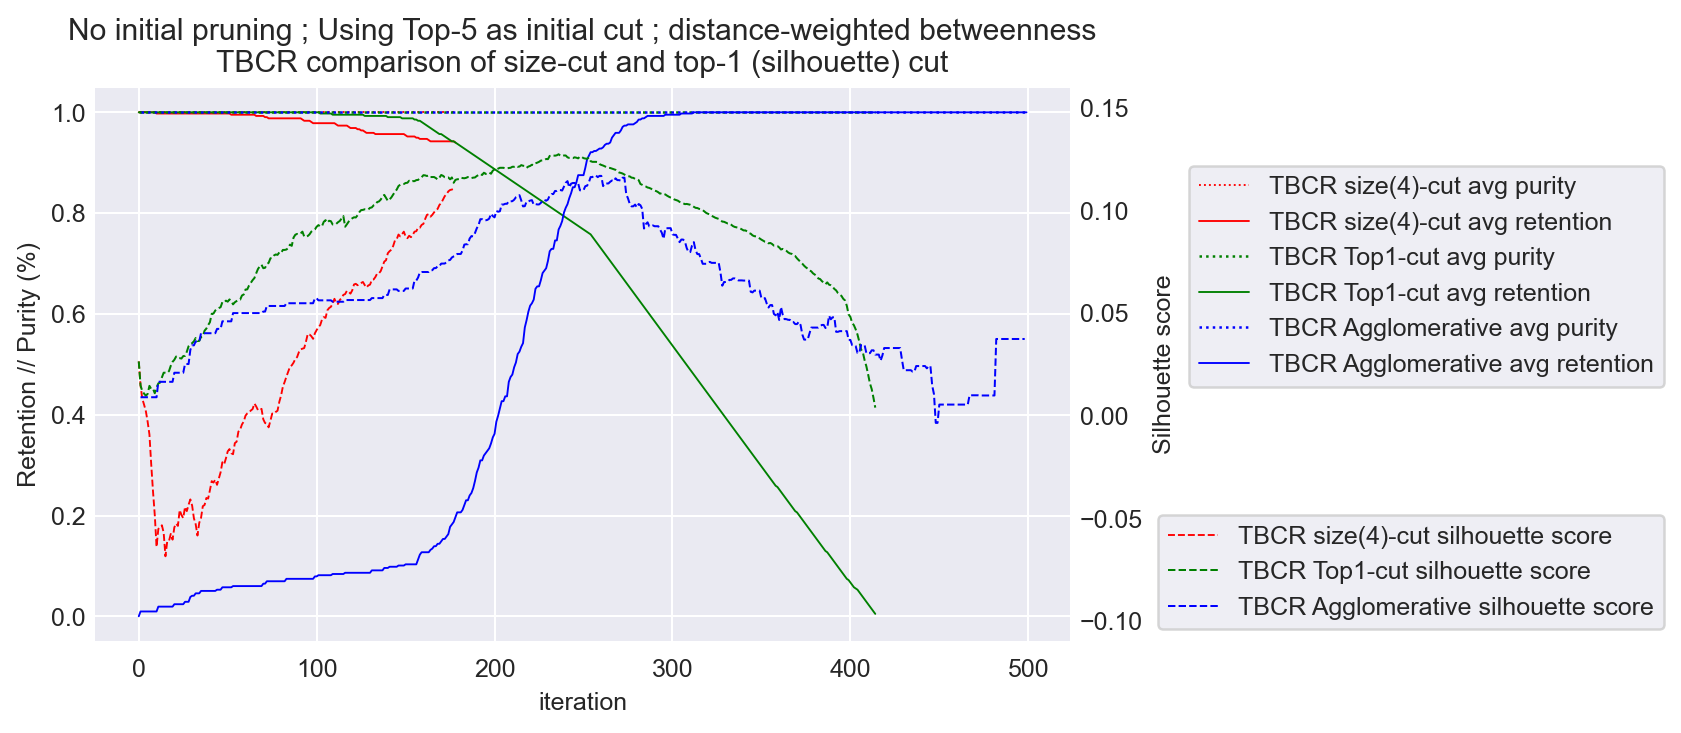

In [97]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning ; Using Top-5 as initial cut ; distance-weighted betweenness\nTBCR comparison of size-cut and top-1 (silhouette) cut')

a.plot(range(len(size_purities)), size_purities, lw=.75, ls=':', c='r',
       label='TBCR size(4)-cut avg purity')
a.plot(range(len(size_retentions)), size_retentions, lw=.75, ls='-', c='r',
       label='TBCR size(4)-cut avg retention')
a2.plot(range(len(size_scores)), size_scores, lw=.75, ls='--', c='r',
       label='TBCR size(4)-cut silhouette score')

a.plot(range(len(topn_purities)), topn_purities, lw=1, ls=':', c='g',
       label='TBCR Top1-cut avg purity')
a.plot(range(len(topn_retentions)), topn_retentions, lw=.75, ls='-', c='g',
       label='TBCR Top1-cut avg retention')
a2.plot(range(len(topn_scores)), topn_scores, lw=.8, ls='--', c='g',
       label='TBCR Top1-cut silhouette score')

a.plot(range(len(cluster_test['mean_purity'].values)), cluster_test['mean_purity'].values, lw=1, ls=':', c='b',
       label='TBCR Agglomerative avg purity')
a.plot(range(len(cluster_test['retention'].values)), cluster_test['retention'].values, lw=.75, ls='-', c='b',
       label='TBCR Agglomerative avg retention')
a2.plot(range(len(cluster_test['silhouette'].values)), cluster_test['silhouette'].values, lw=.8, ls='--', c='b',
       label='TBCR Agglomerative silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.88))
# f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}TBCR_silhouette.png', dpi=150, bbox_inches='tight')


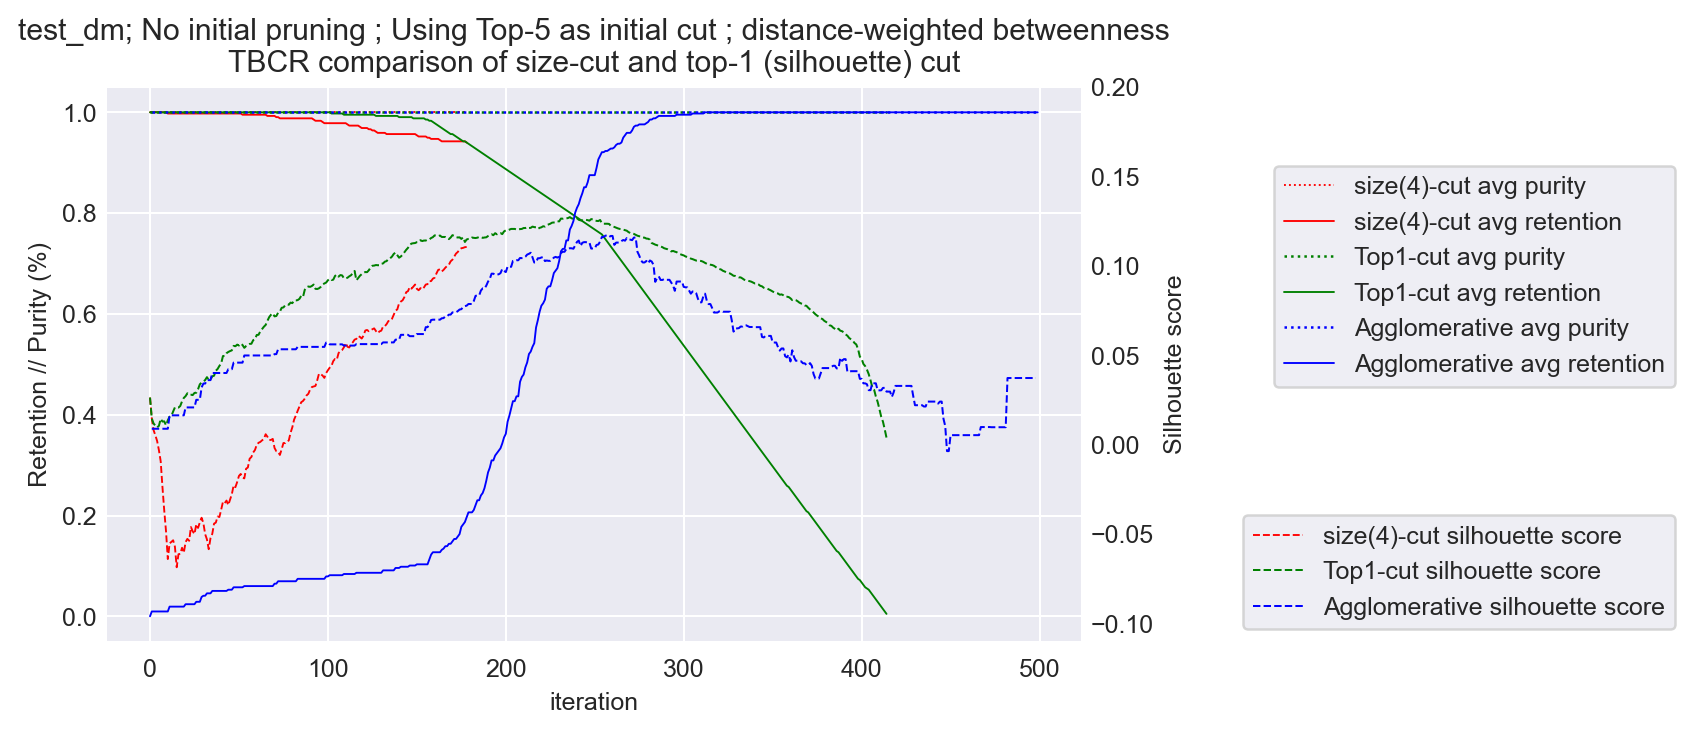

In [99]:
from src.cluster_utils import get_silhouette_plot

get_silhouette_plot(size_purities, size_retentions, size_scores,
                    topn_purities, topn_retentions, topn_scores,
                    cluster_test['mean_purity'].values, cluster_test['retention'].values, cluster_test['silhouette'].values,
                    'test_dm', '../output/', 'test_fn')

### retpur curves

In [ ]:
# Identify best point (based on Silhouette score) for each of the 4 conditions and add them as scatter points
best_sh_ts128 = sh_rets_ts128[np.argmax(sh_scores_ts128)], sh_purities_ts128[np.argmax(sh_scores_ts128)]
best_it_ts128 = it_rets_ts128[np.argmax(it_scores_ts128)], it_purities_ts128[np.argmax(it_scores_ts128)]
best_sh_os128 = sh_rets_os128[np.argmax(sh_scores_os128)], sh_purities_os128[np.argmax(sh_scores_os128)]
best_it_os128 = it_rets_os128[np.argmax(it_scores_os128)], it_purities_os128[np.argmax(it_scores_os128)]
best_sh_os256 = sh_rets_os256[np.argmax(sh_scores_os256)], sh_purities_os256[np.argmax(sh_scores_os256)]
best_it_os256 = it_rets_os256[np.argmax(it_scores_os256)], it_purities_os256[np.argmax(it_scores_os256)]
best_sh_agg = sh_rets_agg[np.argmax(sh_scores_agg)], sh_purities_agg[np.argmax(sh_scores_agg)]
best_it_agg = it_rets_agg[np.argmax(it_scores_agg)], it_purities_agg[np.argmax(it_scores_agg)]
best_tbcr_sh = tbcr_sh_rets[np.argmax(tbcr_sh_scores)], tbcr_sh_purities[np.argmax(tbcr_sh_scores)]
best_tbcr_it = tbcr_it_rets[np.argmax(tbcr_it_scores)], tbcr_it_purities[np.argmax(tbcr_it_scores)]
best_tcrdist_sh = tcrdist_sh_rets[np.argmax(tcrdist_sh_scores)], tcrdist_sh_purities[np.argmax(tcrdist_sh_scores)]
best_tcrdist_it = tcrdist_it_rets[np.argmax(tcrdist_it_scores)], tcrdist_it_purities[np.argmax(tcrdist_it_scores)]



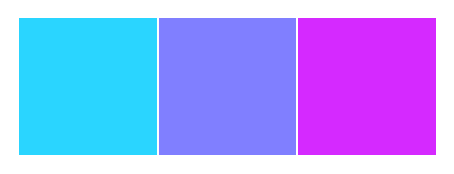

In [102]:
palette=get_palette('cool', 3)
sns.palplot(palette)

[autoreload of src.cluster_utils failed: Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/riwa/Documents/code/tclustr/src/cluster_utils.py

NameError: name 'tbcr_cluster_testset' is not defined

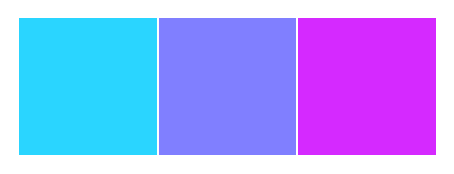

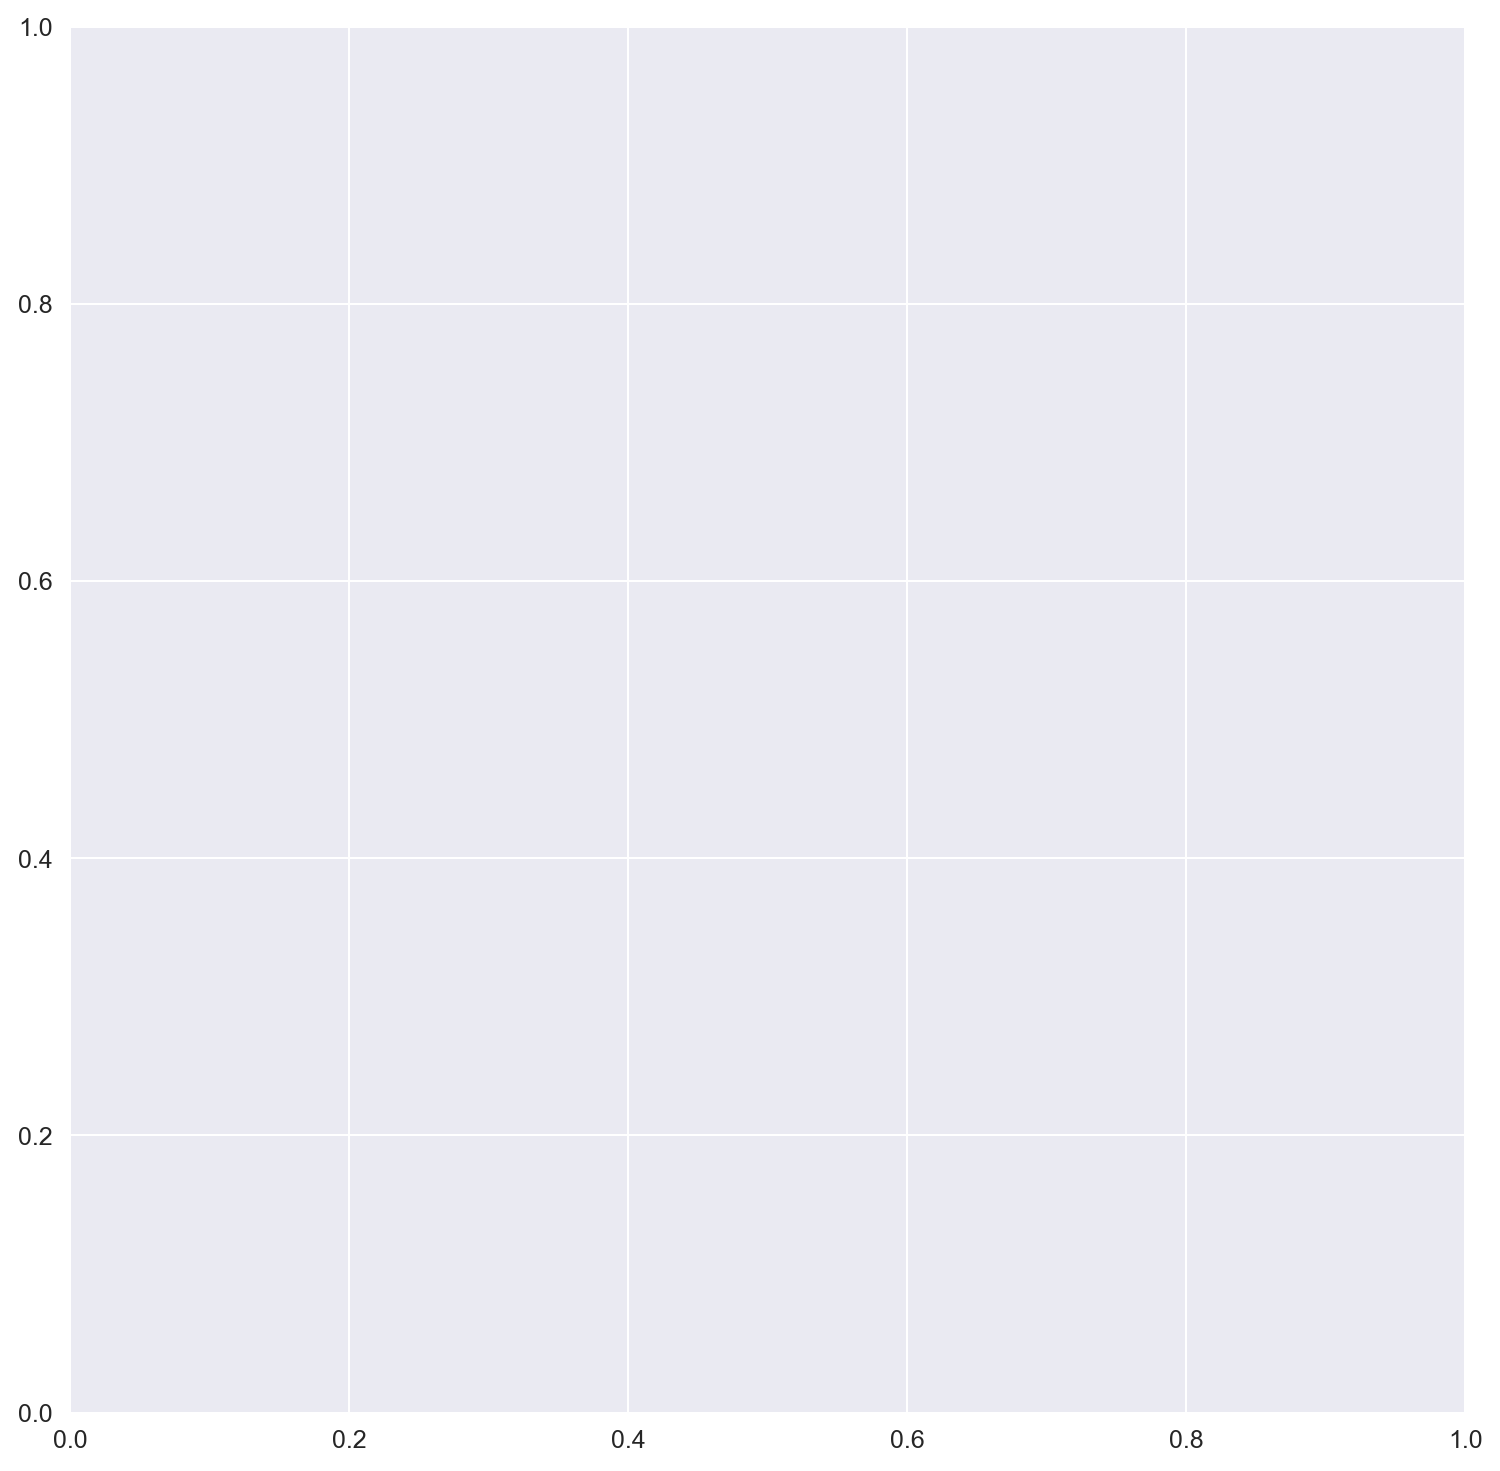

In [100]:
palette=get_palette('cool', 3)
sns.palplot(palette)
c_ts128 = palette[0]
c_os128 = palette[1]
c_os256 = palette[2]
c_agg = 'r'
c_tbcr='g'
c_tcrdist='y'
f,a = plt.subplots(1,1, figsize=(10, 10))
lw=.75
marker_size=12
marker='*'
# TBCRalign
a.plot(tbcr_cluster_testset['retention'].values[1:-1], tbcr_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TBCRalign + Agglomerative Clustering', lw=0.5, ls='-', c=c_tbcr)
a.plot(tbcr_sh_rets, tbcr_sh_purities, label = 'TBCRalign MST + Top 1 Cut', lw = lw, ls='--', c=c_tbcr)
a.scatter(best_tbcr_sh[0], best_tbcr_sh[1], c=c_tbcr, label = 'Best (Silhouette) TBCRalign MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)

# tcrdist3
a.plot(tcrdist_cluster_testset['retention'].values[1:-1], tcrdist_cluster_testset['mean_purity'].values[1:-1], 
       label = 'tcrdist + Agglomerative Clustering', lw=0.5, ls='-', c=c_tcrdist)
a.plot(tcrdist_sh_rets, tcrdist_sh_purities, label = 'tcrdist3 MST + Top 1 Cut', lw = lw, ls='--', c=c_tcrdist)
a.scatter(best_tcrdist_sh[0], best_tcrdist_sh[1], c=c_tcrdist, label = 'Best (Silhouette) tcrdist3 MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)


# TS128
a.plot(ts128_cluster_testset['retention'].values[1:-1], ts128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_ts128)
a.plot(sh_rets_ts128, sh_purities_ts128, label = 'TS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_ts128)
a.scatter(best_sh_ts128[0], best_sh_ts128[1], c=c_ts128, label = 'Best (Silhouette) TS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS128
a.plot(os128_cluster_testset['retention'].values[1:-1], os128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os128)

a.plot(sh_rets_os128, sh_purities_os128, label = 'OS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_os128)
a.scatter(best_sh_os128[0], best_sh_os128[1], c=c_os128, label = 'Best (Silhouette) OS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS256
a.plot(os256_cluster_testset['retention'].values[1:-1], os256_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS256 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os256)

a.plot(sh_rets_os256, sh_purities_os256, label = 'OS256 MST + Top 1 Cut', lw = lw, ls='--', c=c_os256)
a.scatter(best_sh_os256[0], best_sh_os256[1], c=c_os256, label = 'Best (Silhouette) OS256 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# Aggregated
a.plot(agg_cluster_testset['retention'].values[1:-1], agg_cluster_testset['mean_purity'].values[1:-1], 
       label = 'AggDM + Agglomerative Clustering', lw=0.5, ls='-', c=c_agg)

a.plot(sh_rets_agg, sh_purities_agg, label = 'AggDM MST + Top 1 Cut', lw = lw, ls='--', c=c_agg)
a.scatter(best_sh_agg[0], best_sh_agg[1], c=c_agg, label = 'Best (Silhouette) AggDM MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

a.legend()
a.set_ylim([.5,1.])
a.set_xlim([.5,1.])
a.set_xlabel('Retention', fontsize=12, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=12, fontweight='semibold')
a.set_title('Purity Retention curves for valid set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting ; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)

# Cancer

In [965]:
ebh.query('Subject=="hpv15"')

,filename,relpath,Run,Link,Author,Disease,CancerType,Age,Longitudinal,Species,Strain,TSource,TType,TSubtype,Treatment,Subject,Sequences,n_seq,n_unique
33,SRR15178153_1_Paired_All.csv,../data/OTS/human/SRR15178153_1_Paired_All.csv,SRR15178153,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,Eberhardt et al. 2021,cancer,hpv+_hnscc,no,no,human,none,tumor,cd8+,tetramer_qvd,untreated,hpv15,994,994,15
273,SRR15178156_1_Paired_All.csv,../data/OTS/human/SRR15178156_1_Paired_All.csv,SRR15178156,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,Eberhardt et al. 2021,cancer,hpv+_hnscc,no,no,human,none,tumor,cd8+,tetramer_ksa,untreated,hpv15,1034,1034,14


In [970]:
hpv15_ksa, _ = read_ots_data('../data/OTS/human/SRR15178156_1_Paired_All.csv')
hpv15_qvd, _ = read_ots_data('../data/OTS/human/SRR15178153_1_Paired_All.csv')

In [964]:
# Two HPV-specific peptides tetramers : QVDYYGLYY (A0101), KSAIVTLTY (A01-01)
# and PD-1+ for the immune blockade pathway 
ebh = meta_df.query('Author.str.contains("Eber")')
ebh.groupby(['Subject','TSource', 'TSubtype', 'Treatment', 'CancerType']).agg(count=('n_seq','count'),
                                                                              avg_seq = ('n_seq','mean'),
                                                                              max_seq = ('n_seq', 'max'),
                                                                              min_seq = ('n_seq', 'min'),
                                                                              avg_unique = ('n_unique', 'mean'),
                                                                              max_unique = ('n_unique', 'max'),
                                                                              min_unique = ('n_unique', 'min'))

count  \
Subject TSource               TSubtype     Treatment CancerType          
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc      1   
                              tetramer_qvd untreated hpv+_hnscc      1   
hpv34   metastatic_lymph_node pd1+         untreated hpv+_hnscc      3   
                              tetramer_ksa untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
        tumor                 pd1+         untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
hpv37   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc      1   
hpv42   tumor                 tetramer_qvd untreated hpv+_hnscc      3   
hpv51   metastatic_lymph_node pd1+         untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
        tumor                 pd1+         untreated hpv+_hnscc      3   
                              tetramer_ksa untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
hpv7    metastatic_lymph_node pd1+         untreated hpv+_hnscc      3   
                              tetramer_ksa untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
        tumor                 pd1+         untreated hpv+_hnscc      3   
                              tetramer_ksa untreated hpv+_hnscc      3   

                                                                     avg_seq  \
Subject TSource               TSubtype     Treatment CancerType                
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc  1034.000000   
                              tetramer_qvd untreated hpv+_hnscc   994.000000   
hpv34   metastatic_lymph_node pd1+         untreated hpv+_hnscc  2808.666667   
                              tetramer_ksa untreated hpv+_hnscc   236.333333   
                              tetramer_qvd untreated hpv+_hnscc   709.000000   
        tumor                 pd1+         untreated hpv+_hnscc  2896.333333   
                              tetramer_qvd untreated hpv+_hnscc   151.000000   
hpv37   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc   105.000000   
hpv42   tumor                 tetramer_qvd untreated hpv+_hnscc   178.666667   
hpv51   metastatic_lymph_node pd1+         untreated hpv+_hnscc  1909.333333   
                              tetramer_qvd untreated hpv+_hnscc   262.333333   
        tumor                 pd1+         untreated hpv+_hnscc  1368.000000   
                              tetramer_ksa untreated hpv+_hnscc    10.333333   
                              tetramer_qvd untreated hpv+_hnscc  1676.000000   
hpv7    metastatic_lymph_node pd1+         untreated hpv+_hnscc  1178.666667   
                              tetramer_ksa untreated hpv+_hnscc  2908.000000   
                              tetramer_qvd untreated hpv+_hnscc  1837.666667   
        tumor                 pd1+         untreated hpv+_hnscc  1397.666667   
                              tetramer_ksa untreated hpv+_hnscc   744.666667   

                                                                 max_seq  \
Subject TSource               TSubtype     Treatment CancerType            
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc     1034   
                              tetramer_qvd untreated hpv+_hnscc      994   
hpv34   metastatic_lymph_node pd1+         untreated hpv+_hnscc     2813   
                              tetramer_ksa untreated hpv+_hnscc      238   
                              tetramer_qvd untreated hpv+_hnscc      711   
        tumor                 pd1+         untreated hpv+_hnscc     2903   
                              tetramer_qvd untreated hpv+_hnscc      154   
hpv37   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc      105   
hpv42   tumor                 tetramer_qvd untreated hpv+_hnscc      

# Make merged Garner dfs

In [1011]:
%mkdir ../data/OTS/garner_merged/

In [1012]:
pd.set_option('display.max_rows',99)
garner=meta_df.query('Author.str.contains("Garner")')
garner.groupby(['Subject','Run', 'Age', 'TSource','TType', 'TSubtype',]).count()

filename  \
Subject         Run         Age TSource        TType TSubtype                              
2.1_2.3_2.5_2.8 SRR25410120 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410121 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410122 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410123 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410124 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410125 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410126 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410127 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410128 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410129 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410130 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410131 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
2.2_2.4_2.6_2.7 SRR25410108 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410109 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410110 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410111 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410112 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410113 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410114 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410115 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410116 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410117 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410118 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
                SRR25410119 no  pbmc_and_liver cd8+  il12_il18_cd28_stimulated         1   
4.1_4.2_4.3     SRR25409086 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409111 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409112 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409113 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409114 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409115 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409116 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409120 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409121 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409122 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409123 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409124 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409125 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409126 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409127 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409128 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409129 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409130 no  pbmc           cd8+  il12_il18_cd28_stimulated         1   
                SRR25409131 no  

In [1071]:
meta_df.query('Author.str.contains("Garner")').Subject.unique()

array(['4.1_4.2_4.3', '2.2_2.4_2.6_2.7', '2.1_2.3_2.5_2.8'], dtype=object)

In [1235]:
subset=['B1', 'B2', 'B3',   'A1', 'A2', 'A3']
for name in meta_df.query('Author.str.contains("Garner")').Subject.unique():
    relpaths = garner.query('Subject==@name').relpath.unique()
    dfs = [read_ots_unique(f)[0] for f in relpaths]
    garner_merged = pd.concat(dfs)
    garner_merged = pd.concat(dfs).reset_index(drop=True)
    gb_count=garner_merged.loc[garner_merged.duplicated(subset=subset, keep=False)].groupby('tcr').agg(n_dupes=('count','count'),
                                                                                        sum_count=('count','sum'),
                                                                                        mean_count=('count','mean'),
                                                                                        med_count=('count','median'),
                                                                                        max_count=('count','max'))
    garner_merged['duplicated'] = garner_merged.duplicated(subset, keep=False)
    garner_merged = garner_merged.drop_duplicates(subset).set_index('tcr').merge(gb_count[['n_dupes','mean_count','max_count']], 
                                                                                 left_index=True,right_index=True, how='outer')
    garner_merged['count'] = garner_merged.apply(lambda x: x['count'] if not x['duplicated'] else x['max_count'], axis=1).astype(int)
    garner_merged['index_col'] = [f'garner_{i:05}' for i in range(len(garner_merged))]
    garner_merged.to_csv(f'../data/OTS/garner_merged/garner_merged_{name.replace(".","")}.csv')

6724 8256 10007


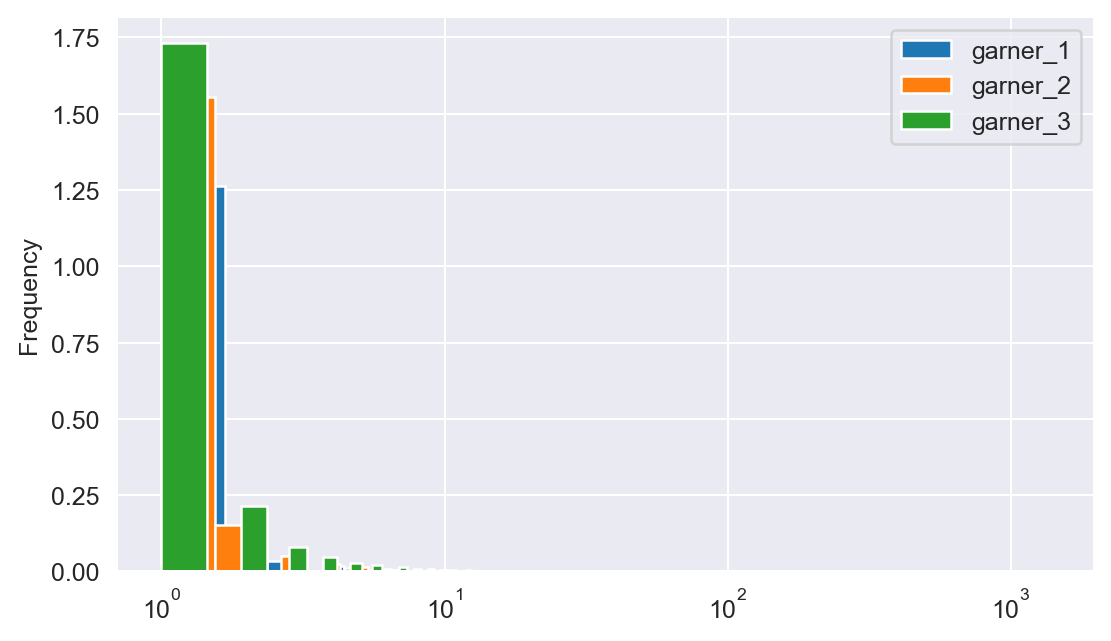

In [1236]:
garner_1 = pd.read_csv('../data/OTS/garner_merged/garner_merged_21_23_25_28.csv').sort_values('count', ascending=False)
garner_2 = pd.read_csv('../data/OTS/garner_merged/garner_merged_22_24_26_27.csv').sort_values('count', ascending=False)
garner_3 = pd.read_csv('../data/OTS/garner_merged/garner_merged_41_42_43.csv').sort_values('count', ascending=False)
fig,ax = plt.subplots(1,1,figsize=(7,4))
garner_1['count'].plot(kind='hist', bins=300, density=True, ax=ax, logx=True, label='garner_1')
garner_2['count'].plot(kind='hist', bins=300, density=True, ax=ax, logx=True, label='garner_2')
garner_3['count'].plot(kind='hist', bins=3000, density=True, ax=ax, logx=True, label='garner_3')
ax.legend()
print(len(garner_1), len(garner_2), len(garner_3))

In [1350]:
def save_sub(fr, garner_3, seed):
    fn=f'../data/OTS/subsampled_francis_garner/subsampled_francis_{i:03}_seed_{seed:03}.txt'
    if os.path.exists(fn):
        df = pd.read_csv(fn)
        return (fn, df.duplicated(subset).any())
    sub = garner_3.sample(n=len(fr), random_state=seed)
    cat = pd.concat([fr, sub]).reset_index(drop=True)
    cat['norm_count'] = cat.apply(lambda x: x['count'] / cat.groupby(['Disease'])['count'].sum()[x['Disease']], axis=1)

    cat.to_csv(f'../data/OTS/subsampled_francis_garner/subsampled_francis_{i:03}_seed_{seed:03}.txt', index=False)
    return (fn, cat.duplicated(subset).any())


In [1269]:
errs = pd.read_csv('../output/errors.txt', sep=' ', header=0, names=['run','xd','id','Yes'])
errs['name'] = errs['run'].apply(lambda x: x.split('_seed')[0])
errs.groupby(['name']).count().query('run<=20')

,run,xd,id,Yes
name,,,,
subsampled_francis_000,16,0,16,16
subsampled_francis_001,14,0,14,14
subsampled_francis_005,20,0,20,20
subsampled_francis_008,15,0,15,15
subsampled_francis_014,19,0,19,19
subsampled_francis_016,16,0,16,16
subsampled_francis_017,13,0,13,13
subsampled_francis_018,16,0,16,16
subsampled_francis_020,17,0,17,17


In [ ]:
# TODO : run mock analysis on these failed runs and get the stats i need/want


In [1351]:
from joblib import Parallel, delayed
%mkdir ../data/OTS/subsampled_francis_garner/
# Stop at 43 because that gives us a dataframe with 1521 seq and that's largest we could run without taking 16 hours
for i in tqdm(range(43), desc='i'):
    fr = pd.read_csv(f'../data/OTS/francis_covid/francis_{i:04}.txt', index_col=0)
    out=Parallel(n_jobs=10)(delayed(save_sub)(fr, garner_3.query('tcr not in @fr.tcr.unique()'), seed) for seed in tqdm(range(100),leave=False,position=0))
    # for seed in range(100):
    #     sub = garner_3.sample(n=len(fr), random_state=seed)
    #     cat = pd.concat([fr, sub]).reset_index(drop=True)
    #     cat['norm_count'] = cat.apply(lambda x: x['count'] / cat.groupby(['Disease'])['count'].sum()[x['Disease']], axis=1)
    #     cat.to_csv(f'../data/OTS/subsampled_francis_garner/subsampled_francis_{i:03}_seed_{seed:03}.txt', index=False)

mkdir: ../data/OTS/subsampled_francis_garner/: File exists


i:   0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [1372]:
def wtf(fr, garner_3, seed):
    return len(garner_3)

def wtf2(i, fr, garner_3, seed):
    return {i:garner_3.query('tcr in @fr.tcr.unique()').index_col.values}



In [1376]:
from joblib import Parallel, delayed
%mkdir ../data/OTS/subsampled_francis_garner/
# Stop at 43 because that gives us a dataframe with 1521 seq and that's largest we could run without taking 16 hours
for i in tqdm(range(43), desc='i'):
    fr = pd.read_csv(f'../data/OTS/francis_covid/francis_{i:04}.txt', index_col=0)
    out1=Parallel(n_jobs=10)(delayed(wtf)(fr, garner_3.query('tcr not in @fr.tcr.unique()'), seed) for seed in tqdm(range(100),leave=False,position=0))
    out2=Parallel(n_jobs=10)(delayed(wtf2)(i, fr, garner_3, seed) for seed in tqdm(range(100),leave=False,position=0))
    # for seed in range(100):
    #     sub = garner_3.sample(n=len(fr), random_state=seed)
    #     cat = pd.concat([fr, sub]).reset_index(drop=True)
    #     cat['norm_count'] = cat.apply(lambda x: x['count'] / cat.groupby(['Disease'])['count'].sum()[x['Disease']], axis=1)
    #     cat.to_csv(f'../data/OTS/subsampled_francis_garner/subsampled_francis_{i:03}_seed_{seed:03}.txt', index=False)

mkdir: ../data/OTS/subsampled_francis_garner/: File exists


i:   0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [1345]:
xd=pd.read_csv('../data/OTS/subsampled_francis_garner/subsampled_francis_042_seed_077.txt')
xd.loc[xd.duplicated(subset, keep=False)][['tcr', 'index_col']]

,tcr,index_col


In [1352]:
[x for x in out if x[1]]

[]

# Do run merging Covid (Francis) and Healthy (Garner) studies

<Axes: title={'center': 'Garner Healthy'}, ylabel='Frequency'>

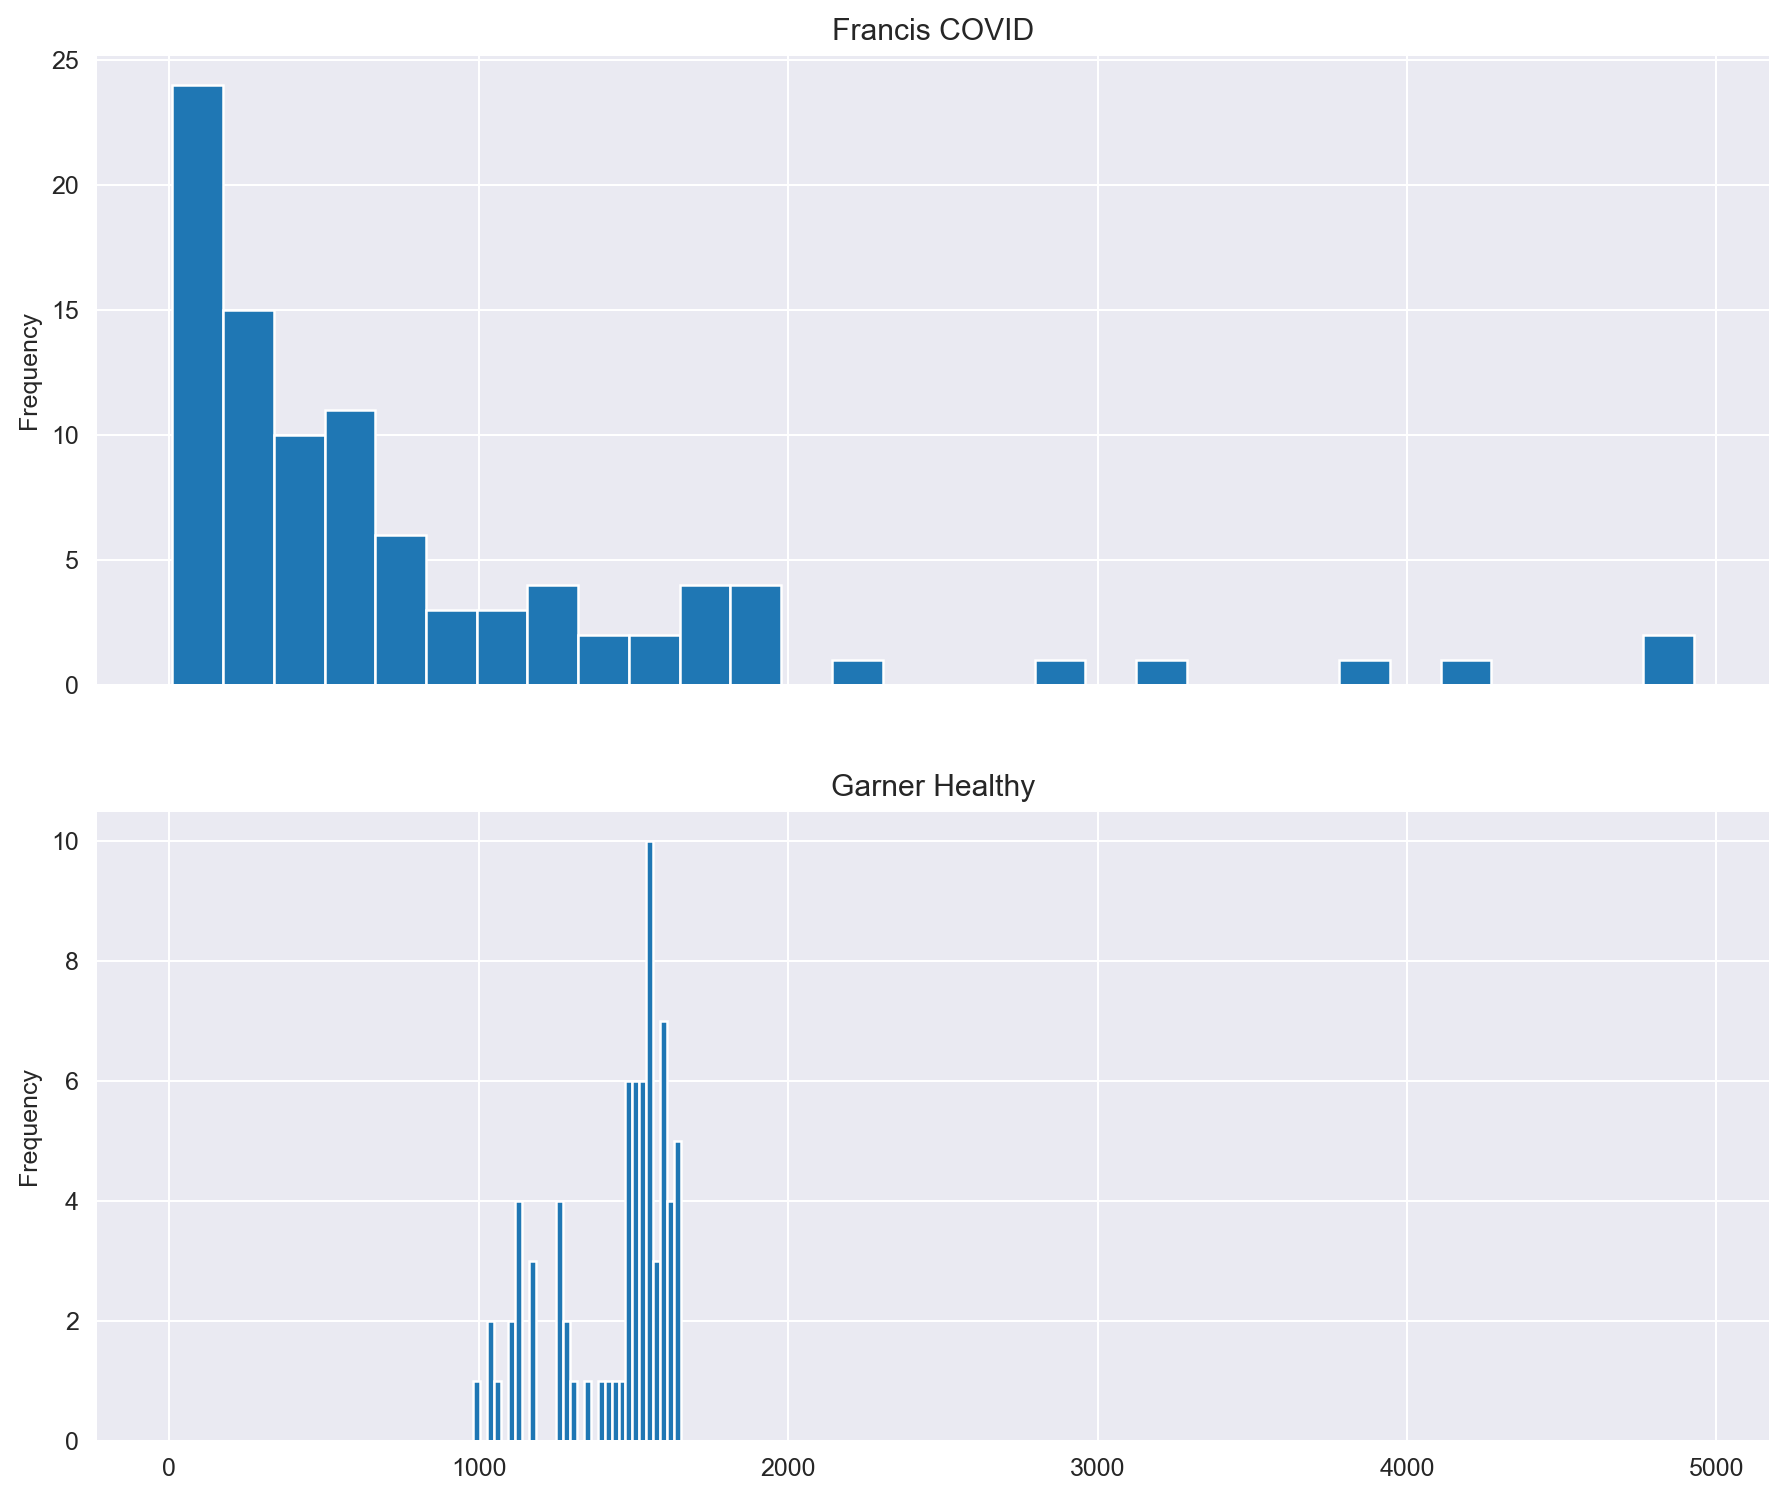

In [40]:
garner_pbmc = meta_df.query('Author.str.contains("Garner")').query('TSource=="pbmc"')
francis_pbmc = meta_df.query('Author.str.contains("Franc")')
f,a = plt.subplots(2,1, figsize=(12,10), sharex=True)
ax = a.ravel()
francis_pbmc.n_unique.plot(kind='hist', bins=30, ax = ax[0], title='Francis COVID')
garner_pbmc.n_unique.plot(kind='hist', bins=30, ax = ax[1], title='Garner Healthy')

In [855]:
n=160
print(len(garner_pbmc.query("n_unique>=@n")),len(francis_pbmc.query("n_unique>=@n")))
garner_160 = garner_pbmc.query("n_unique>=@n").sort_values('n_unique')
francis_160 = francis_pbmc.query("n_unique>=@n").sort_values('n_unique')

72 72


In [94]:
%mkdir ../data/OTS/mixed_covid_healthy/

In [843]:
for i in range(len(garner_160)):
    # Do a zip and get the two files, read the dfs, and merge
    garner = garner_160.iloc[i]
    francis = francis_160.iloc[i]
    garner, garner_metadata = read_ots_unique(garner['relpath'])
    francis, francis_metadata = read_ots_unique(francis['relpath'])
    garner['index_col'] = [f'garner_{i:04}' for i in range(len(garner))]
    francis['index_col'] = [f'francis_{i:04}' for i in range(len(francis))]
    mixed = pd.concat([garner, francis])
    mixed['norm_count'] = mixed.apply(lambda x: x['count'] / mixed.groupby(['Disease'])['count'].sum()[x['Disease']], axis=1)
    mixed.to_csv(f'../data/OTS/mixed_covid_healthy/mixed_{i:04}.txt')

In [859]:
%mkdir ../data/OTS/francis_covid/
for i in range(len(francis_160)):
    # Do a zip and get the two files, read the dfs, and merge
    francis = francis_160.iloc[i]
    # garner, garner_metadata = read_ots_unique(garner['relpath'])
    francis, francis_metadata = read_ots_unique(francis['relpath'])
    # garner['index_col'] = [f'garner_{i:04}' for i in range(len(garner))]
    francis['index_col'] = [f'francis_{i:04}' for i in range(len(francis))]
    # mixed = pd.concat([garner, francis])
    # mixed['norm_count'] = mixed.apply(lambda x: x['count'] / mixed.groupby(['Disease'])['count'].sum()[x['Disease']], axis=1)
    francis.to_csv(f'../data/OTS/francis_covid/francis_{i:04}.txt')

mkdir: ../data/OTS/francis_covid/: File exists


In [860]:
%ls ../data/OTS/francis_covid

francis_0000.txt  francis_0018.txt  francis_0036.txt  francis_0054.txt
francis_0001.txt  francis_0019.txt  francis_0037.txt  francis_0055.txt
francis_0002.txt  francis_0020.txt  francis_0038.txt  francis_0056.txt
francis_0003.txt  francis_0021.txt  francis_0039.txt  francis_0057.txt
francis_0004.txt  francis_0022.txt  francis_0040.txt  francis_0058.txt
francis_0005.txt  francis_0023.txt  francis_0041.txt  francis_0059.txt
francis_0006.txt  francis_0024.txt  francis_0042.txt  francis_0060.txt
francis_0007.txt  francis_0025.txt  francis_0043.txt  francis_0061.txt
francis_0008.txt  francis_0026.txt  francis_0044.txt  francis_0062.txt
francis_0009.txt  francis_0027.txt  francis_0045.txt  francis_0063.txt
francis_0010.txt  francis_0028.txt  francis_0046.txt  francis_0064.txt
francis_0011.txt  francis_0029.txt  francis_0047.txt  francis_0065.txt
francis_0012.txt  francis_0030.txt  francis_0048.txt  francis_0066.txt
francis_0013.txt  francis_0031.txt  francis_0049.txt  francis_0067.txt
franci

In [89]:
g0 = garner_160.iloc[0]
f0 = francis_160.iloc[0]
garner, _ = read_ots_unique(g0['relpath'])
francis, _ = read_ots_unique(f0['relpath'])
garner['index_col'] = [f'garner_{i:04}' for i in range(len(garner))]
francis['index_col'] = [f'francis_{i:04}' for i in range(len(francis))]
mixed_test = pd.concat([garner.sample(100, random_state=13), francis.sample(100, random_state=13)])
mixed_test.to_csv('../data/OTS/mixed_test_data.csv', index=False)

In [90]:
mixed_test.head(2)

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,...,A2,A3,Link,Disease,CancerType,Source,Subject,count,Run,index_col
611,TSGFNGNVLDGLAVMDSNYQLIWNHNNSYGVQDASSDRDTGELF,TRBV10-1*01,TRBD1*01,TRBJ2-2*01,WNHNN,SYGVQD,ASSDRDTGELF,TRAV1-2*01,NaN,TRAJ33*01,...,NVLDGL,AVMDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,2,SRR25409128,garner_0611
814,TSGFNGNVLDGLAVRDSDYKLSMRHNASNTAGTASSPGGPSGANVLT,TRBV6-4*02,TRBD2*01,TRBJ2-6*01,MRHNA,SNTAGT,ASSPGGPSGANVLT,TRAV1-2*01,NaN,TRAJ20*01,...,NVLDGL,AVRDSDYKLS,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1,SRR25409128,garner_0814


In [79]:
dm = pd.read_csv('../data/mixed_test_data_TBCR_distmatrix.csv', index_col=0)
dm

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,Disease,Source,count
q_index,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.141811,0.127153,0.122996,0.111405,0.106975,0.085607,0.106382,0.111616,0.099076,...,0.178386,0.190997,0.181785,0.186164,0.183630,0.193406,0.228023,healthy,pbmc,2
1,0.141811,0.000000,0.073688,0.113270,0.144548,0.134624,0.118861,0.151282,0.108692,0.121867,...,0.188008,0.190229,0.200785,0.194458,0.164207,0.204848,0.210851,healthy,pbmc,1
2,0.127153,0.073688,0.000000,0.091515,0.125295,0.119858,0.110294,0.133866,0.102694,0.108938,...,0.169953,0.160391,0.181860,0.179263,0.160146,0.193510,0.219921,healthy,pbmc,1
3,0.122996,0.113270,0.091515,0.000000,0.138677,0.119663,0.112965,0.156350,0.125653,0.122678,...,0.193152,0.172840,0.153881,0.187570,0.175297,0.200072,0.211785,healthy,pbmc,2
4,0.111405,0.144548,0.125295,0.138677,0.000000,0.107202,0.108565,0.071701,0.119859,0.115201,...,0.168632,0.153100,0.189398,0.199578,0.204705,0.188562,0.213830,healthy,pbmc,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.181785,0.200785,0.181860,0.153881,0.189398,0.191139,0.165232,0.208100,0.191741,0.163233,...,0.207963,0.169868,0.000000,0.182608,0.194420,0.222556,0.223013,covid,pbmc,1
196,0.186164,0.194458,0.179263,0.187570,0.199578,0.199532,0.195456,0.206798,0.182914,0.192035,...,0.180796,0.176192,0.182608,0.000000,0.155323,0.219110,0.204618,covid,pbmc,2
197,0.183630,0.164207,0.160146,0.175297,0.204705,0.189491,0.175044,0.211471,0.162908,0.180056,...,0.181114,0.186666,0.194420,0.155323,0.000000,0.203289,0.229157,covid,pbmc,1


# Testing my pipeline functions


In [537]:
model_ts128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/epoch_5000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj_JSON_kwargs.json',
                              map_location='cpu', verbose=False)

model_os256 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/epoch_8000_interval_checkpoint__fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02_JSON_kwargs.json',
                              map_location='cpu', verbose=False)

model_os128_notrp = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni.pt',
                                    '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni_JSON_kwargs.json',
                              map_location='cpu', verbose=False)

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 256 9 4 2 1 0 SELU()
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()


In [639]:
df = pd.read_csv('../data/OTS/mixed_covid_healthy/mixed_0000.txt')
df = pd.concat([df.query('Disease=="healthy"').sample(25, random_state=13), df.query('Disease=="covid"').sample(60, random_state=13)])
latent_df = get_latent_df(model_ts128, df)
latent_1 = get_latent_df(model_os128_notrp, df)
latent_2 = get_latent_df(model_os256, df)
# Use other two models to create the fake "tbcr" and "tcrdist" matrices so I don't have to run them
# latent_df['index_col'] = [f'seq_{i:04}' for i in range(len(latent_df))]
label_col='Disease'
index_col='index_col'
rest_cols=['Disease','CancerType','Source', 'Run', 'count']
dist_matrix, values_array, _, labels, encoded_labels, label_encoder = get_distances_labels_from_latent(latent_df, 
                                                                                                       label_col=label_col, 
                                                                                                       index_col=index_col,
                                                                                                       rest_cols=rest_cols)
# Create fake TBCR and tcrdist "dist_matrixes" by just multiplying by noise
dist_matrix_tbcr, values_tbcr, _, labels, encoded_labels, label_encoder = get_distances_labels_from_latent(latent_1, 
                                                                                                       label_col=label_col, 
                                                                                                       index_col=index_col,
                                                                                                       rest_cols=rest_cols)
# Create fake TBCR and tcrdist "dist_matrixes" by just multiplying by noise
dist_matrix_tcrdist, values_array_tcrdist, _, labels, encoded_labels, label_encoder = get_distances_labels_from_latent(latent_2, 
                                                                                                       label_col=label_col, 
                                                                                                       index_col=index_col,
                                                                                                       rest_cols=rest_cols)
# Create fake TBCR and tcrdist "dist_matrixes" by just multiplying by noise

display(dist_matrix[index_col].head())
display(latent_df[index_col].head())

TSGFNGNVLDGLAVMDSNYQLIWNHNNSYGVQDASSDRDTGELF       garner_0611
TSGFNGNVLDGLAVRDSDYKLSMRHNASNTAGTASSPGGPSGANVLT    garner_0814
TSGFNGNVLDGLAVRESDYKLSMRHNASNTAGTASSEVAGGSAEQY     garner_0480
TSGFNGNVLDGLAVRGGDYQLIMRHNASNTAGTASSDSTSGSNEQF     garner_0285
TSGFNGNVLDGLAVSDSNYQLIDFQATTSNEGSKASAREATPQETQY    garner_0675
Name: index_col, dtype: object

0    garner_0611
1    garner_0814
2    garner_0480
3    garner_0285
4    garner_0675
Name: index_col, dtype: object

In [643]:
xx = pd.read_csv('../data/pipeline_test/240827_131755_TEST_OUTDIR_DELETE_ME_MST_vnx75/mixed_test_data_TBCRraw_TMP.txt',
                comment='#', sep = ' ', header= None, index_col=None)

In [648]:
xx.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,ALL,Query,0,TSGFNG,NVLDGL,AVMDSNYQLI,AVMDSNYQLI,WNHNN,SYGVQD,-99.900002,Hit,1,TSGFNG,NVLDGL,AVRDSDYKLS,AVRDSDYKLS,MRHNA,SNTAGT,10.719661,-99.900002
1,ALL,Query,0,TSGFNG,NVLDGL,AVMDSNYQLI,AVMDSNYQLI,WNHNN,SYGVQD,-99.900002,Hit,2,TSGFNG,NVLDGL,AVRESDYKLS,AVRESDYKLS,MRHNA,SNTAGT,10.657727,-99.900002
2,ALL,Query,0,TSGFNG,NVLDGL,AVMDSNYQLI,AVMDSNYQLI,WNHNN,SYGVQD,-99.900002,Hit,3,TSGFNG,NVLDGL,AVRGGDYQLI,AVRGGDYQLI,MRHNA,SNTAGT,10.538446,-99.900002
3,ALL,Query,0,TSGFNG,NVLDGL,AVMDSNYQLI,AVMDSNYQLI,WNHNN,SYGVQD,-99.900002,Hit,4,TSGFNG,NVLDGL,AVSDSNYQLI,AVSDSNYQLI,DFQATT,SNEGSKA,10.936750,-99.900002
4,ALL,Query,0,TSGFNG,NVLDGL,AVMDSNYQLI,AVMDSNYQLI,WNHNN,SYGVQD,-99.900002,Hit,5,TSGFNG,NVLDGL,AASDSNYQLI,AASDSNYQLI,MDHEN,SYDVKM,11.151836,-99.900002


In [636]:
tbcr = pd.read_csv('../data/pipeline_test/mixed_test_data_TBCR_distmatrix.csv', index_col=0)
tcrd = pd.read_csv('../data/pipeline_test/mixed_test_data_tcrdist3_distmatrix_XD123.txt', index_col=0)

In [849]:
dist_matrix_tbcr['norm_count'] = dist_matrix['norm_count'].values
dist_matrix_tcrdist['norm_count'] = dist_matrix['norm_count'].values
latent_df['norm_count'] = dist_matrix['norm_count'].values
df['norm_count'] = dist_matrix['norm_count'].values


In [850]:
%mkdir ../data/pipeline_test/
dist_matrix_tbcr.to_csv('../data/pipeline_test/tbcr_test.txt', index=True)
dist_matrix_tcrdist.to_csv('../data/pipeline_test/tcrdist_test.txt', index=True)
df.to_csv('../data/pipeline_test/inputdf_test.txt', index=False)
latent_df.to_csv('../data/pipeline_test/latentdf_test.txt', index=False)

mkdir: ../data/pipeline_test/: File exists


In [604]:
from src.cluster_utils import do_three_clustering, do_full_clustering_pipeline
size_results, topn_results, agglo_results = do_three_clustering(dist_matrix, label_col, index_col)
size_results, topn_results, agglo_results = do_three_clustering(dist_matrix_tbcr, label_col, index_col)
size_results, topn_results, agglo_results = do_three_clustering(dist_matrix_tcrdist, label_col, index_col)

Initial mean purity, silhouette score, retention
0.8016 0.0751 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

Running clustering pipeline for VAE
Initial mean purity, silhouette score, retention
0.8016 0.0751 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Running clustering pipeline for TBCRalign
Initial mean purity, silhouette score, retention
0.7917 0.098 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Running clustering pipeline for tcrdist3
Initial mean purity, silhouette score, retention
0.7029 0.0298 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

best_vae_topn {'idx': 40, 'purity': 0.9545454545454546, 'retention': 0.8941, 'silhouette': 0.1343}
best_vae_agglo {'idx': 365, 'purity': 0.9859340659340659, 'retention': 1.0, 'silhouette': 0.249627947807312}
best_tbcr_topn {'idx': 42, 'purity': 0.9569892473118279, 'retention': 0.8471, 'silhouette': 0.1645}
best_tbcr_agglo {'idx': 486, 'purity': 0.7740863787375415, 'retention': 1.0, 'silhouette': 0.37237653136253357}
best_tcrdist_topn {'idx': 48, 'purity': 0.988095238095238, 'retention': 0.7412, 'silhouette': 0.1065}
best_tcrdist_agglo {'idx': 344, 'purity': 0.9560185185185186, 'retention': 0.9647058823529412, 'silhouette': 0.258226603269577}


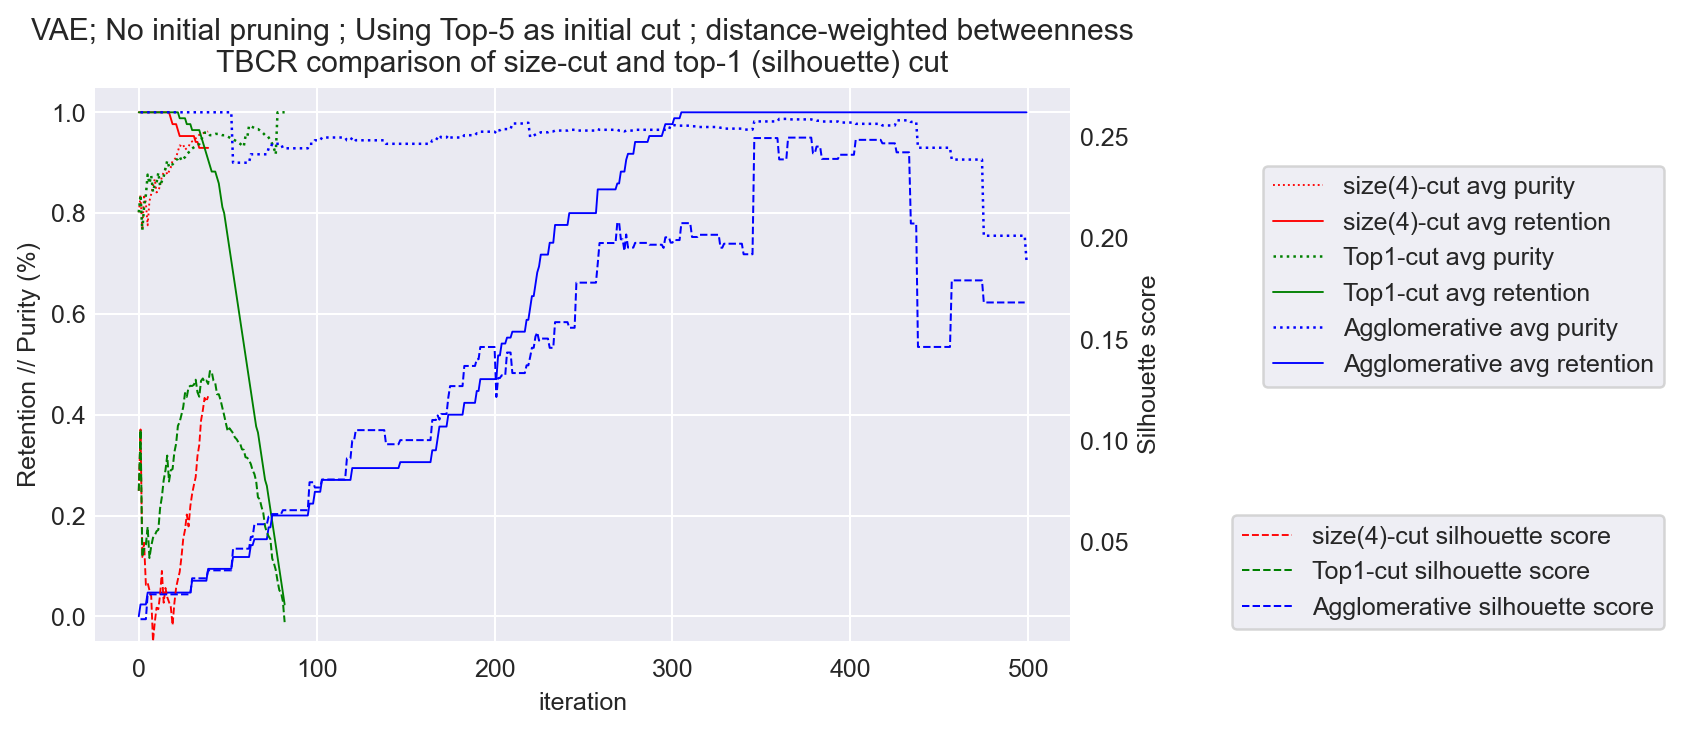

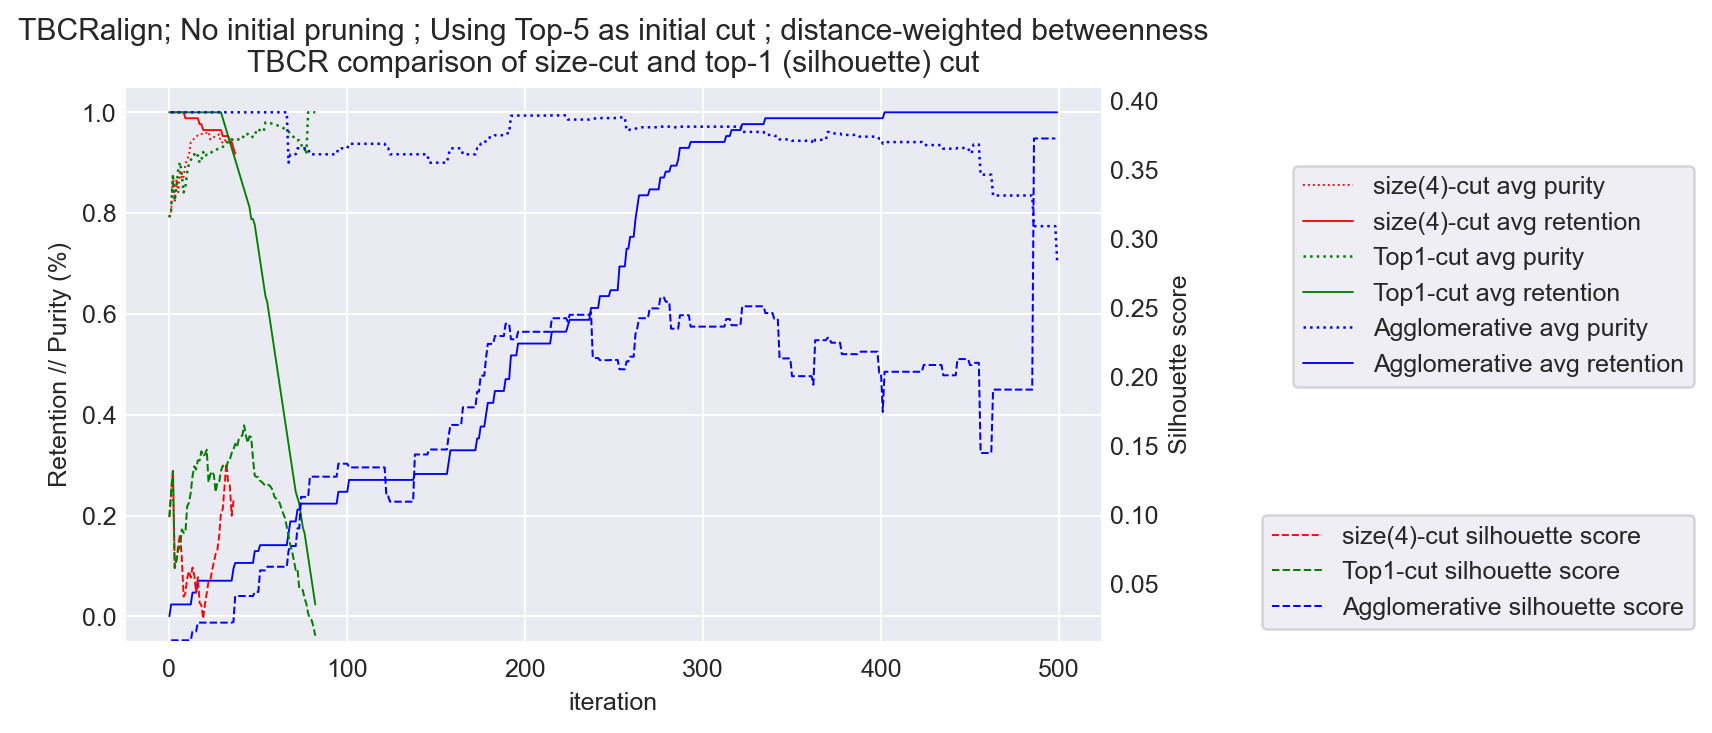

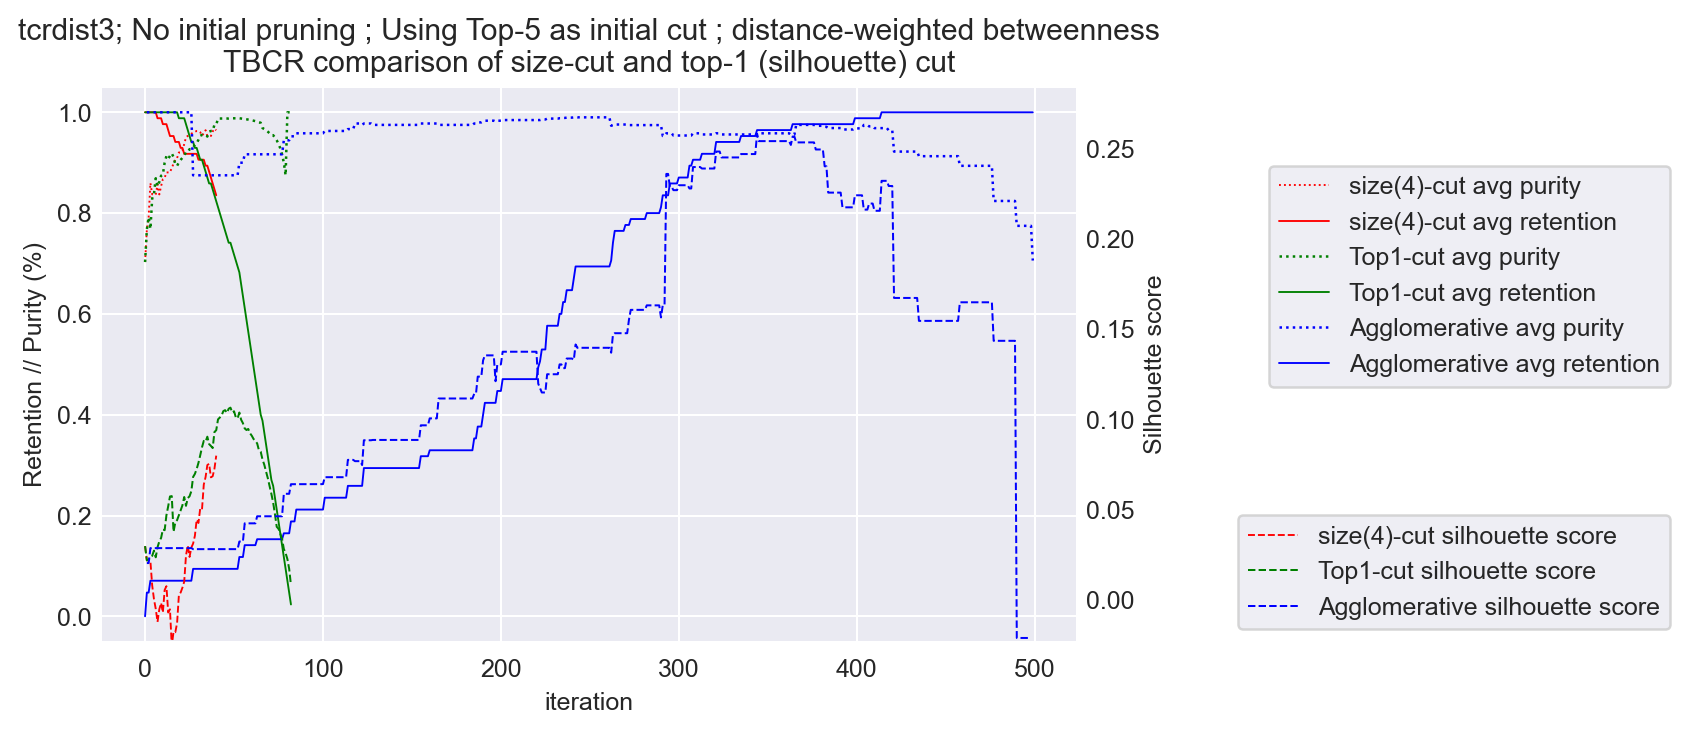

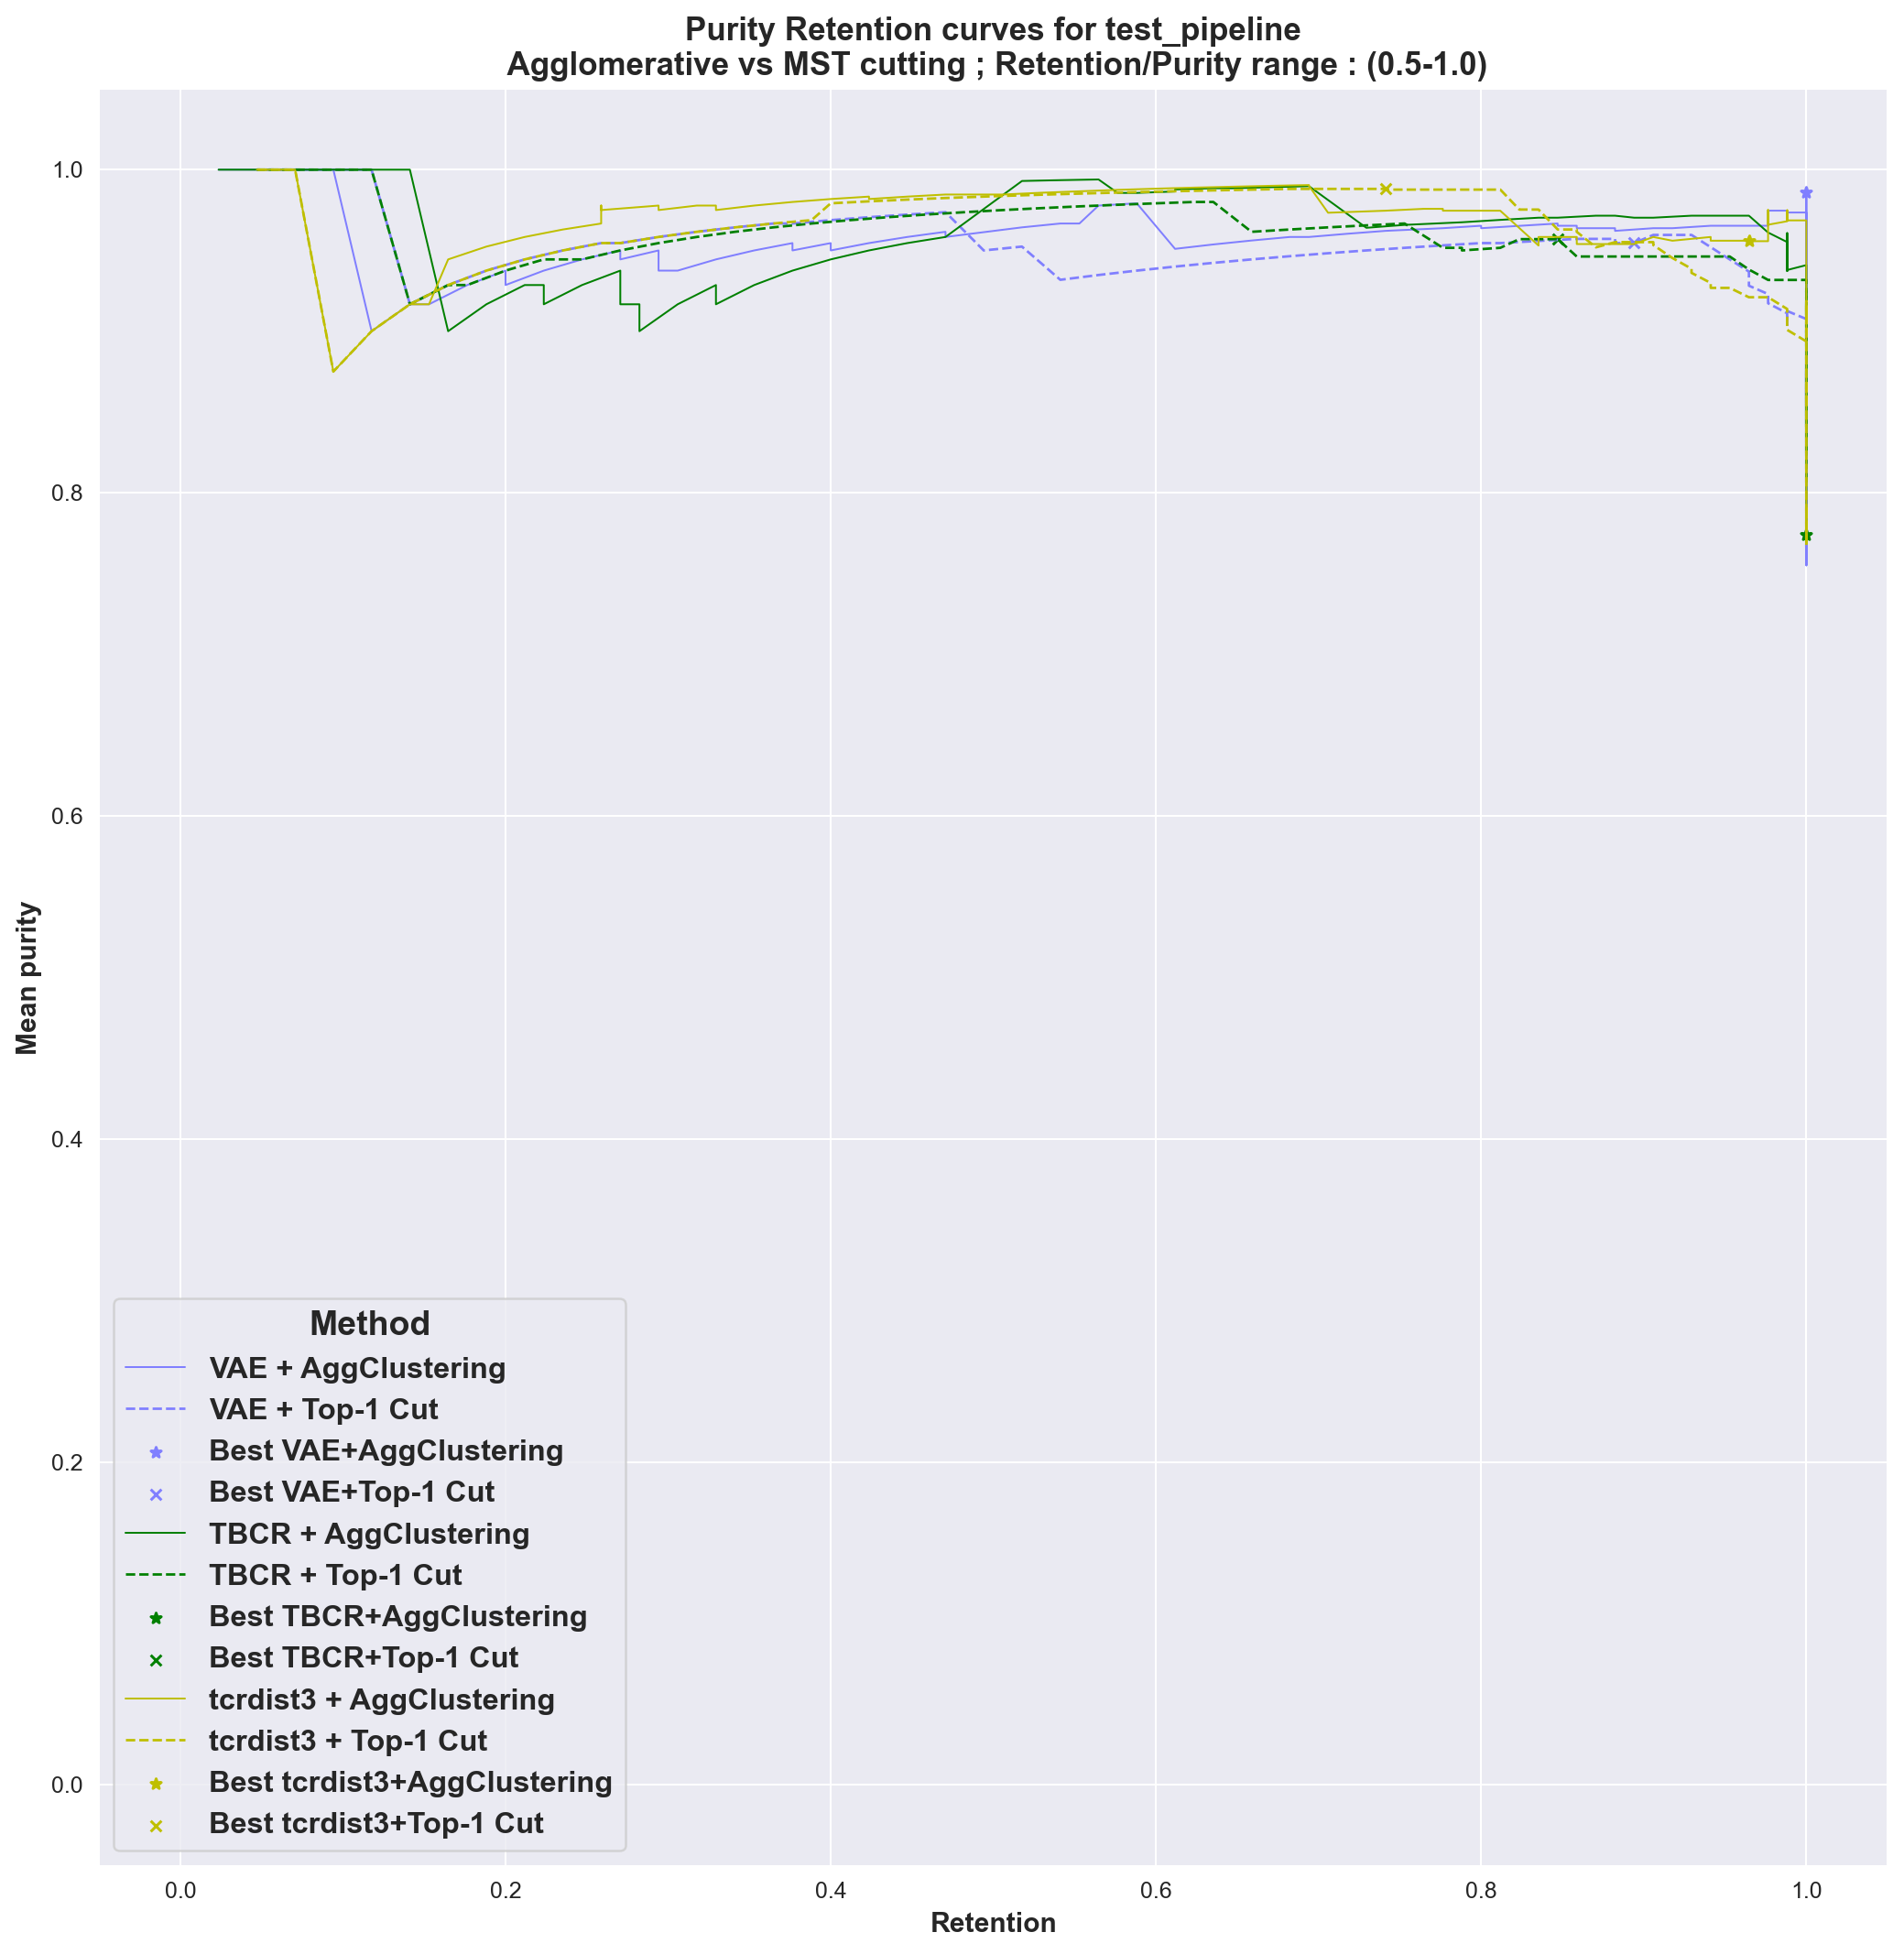

In [626]:
from src.cluster_utils import do_full_clustering_pipeline
_ = do_full_clustering_pipeline(dist_matrix, dist_matrix_tbcr, dist_matrix_tcrdist, label_col=label_col,
                            index_col=index_col, outdir='../output/', filename='_notebook_test_pipeline', title='test_pipeline')

In [854]:
max([x['cluster_size'] for x in size_results['clusters'] if x['majority_label']!='healthy'])

3

In [627]:
resdf_cut = _[0]['df']
resdf_agg = _[2]['df']
display(resdf_cut.head()) 
display(resdf_agg.head())

,node,Disease,index_col,pred_label,cluster_size,majority_label,purity,method
0,24,healthy,garner_0519,0,2,covid,0.500000,size_cut
1,51,covid,francis_0087,0,2,covid,0.500000,size_cut
2,30,covid,francis_0070,1,2,covid,1.000000,size_cut
3,32,covid,francis_0159,1,2,covid,1.000000,size_cut
4,0,healthy,garner_0611,2,3,covid,0.666667,size_cut


,index_col,Disease,pred_label,purity,cluster_size,majority_label,method
78,francis_0138,covid,0,1.0,5,covid,agglo
75,francis_0055,covid,0,1.0,5,covid,agglo
45,francis_0033,covid,0,1.0,5,covid,agglo
27,francis_0069,covid,0,1.0,5,covid,agglo
61,francis_0146,covid,0,1.0,5,covid,agglo


In [629]:
df = df.drop(columns=['Unnamed: 0'])
display(df.head(3))
display(resdf_cut.head(3))

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,...,A3,Link,Disease,CancerType,Source,Subject,count,Run,index_col,len_q
611,TSGFNGNVLDGLAVMDSNYQLIWNHNNSYGVQDASSDRDTGELF,TRBV10-1*01,TRBD1*01,TRBJ2-2*01,WNHNN,SYGVQD,ASSDRDTGELF,TRAV1-2*01,NaN,TRAJ33*01,...,AVMDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,2,SRR25409128,garner_0611,6
814,TSGFNGNVLDGLAVRDSDYKLSMRHNASNTAGTASSPGGPSGANVLT,TRBV6-4*02,TRBD2*01,TRBJ2-6*01,MRHNA,SNTAGT,ASSPGGPSGANVLT,TRAV1-2*01,NaN,TRAJ20*01,...,AVRDSDYKLS,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1,SRR25409128,garner_0814,6
480,TSGFNGNVLDGLAVRESDYKLSMRHNASNTAGTASSEVAGGSAEQY,TRBV6-4*02,TRBD2*01,TRBJ2-7*01,MRHNA,SNTAGT,ASSEVAGGSAEQY,TRAV1-2*01,NaN,TRAJ20*01,...,AVRESDYKLS,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1,SRR25409128,garner_0480,6


,node,Disease,index_col,pred_label,cluster_size,majority_label,purity,method
0,24,healthy,garner_0519,0,2,covid,0.5,size_cut
1,51,covid,francis_0087,0,2,covid,0.5,size_cut
2,30,covid,francis_0070,1,2,covid,1.0,size_cut


In [ ]:
pd.read_csv('../output/

In [619]:
df.merge(resdf_cut['

,node,Disease,index_col,pred_label,cluster_size,majority_label,purity,method
0,24,healthy,garner_0519,0,2,covid,0.500000,size_cut
1,51,covid,francis_0087,0,2,covid,0.500000,size_cut
2,30,covid,francis_0070,1,2,covid,1.000000,size_cut
3,32,covid,francis_0159,1,2,covid,1.000000,size_cut
4,0,healthy,garner_0611,2,3,covid,0.666667,size_cut
...,...,...,...,...,...,...,...,...
80,63,covid,francis_0031,36,1,covid,NaN,size_cut
81,74,covid,francis_0103,37,1,covid,NaN,size_cut
82,75,covid,francis_0055,38,1,covid,NaN,size_cut
83,76,covid,francis_0137,39,1,covid,NaN,size_cut


In [650]:
res = pkl_load('../output/240827_MixedCovidHealthyMST/240827_171807_FULLPIPELINE_mixed_0001_MST_VmeTx/result_TBCRalign_agglo.pkl')

res.keys()

dict_keys(['scores', 'purities', 'retentions', 'best'])

In [658]:
np.argmax(np.where(np.isnan(res['scores']), -999, res['scores']))

254

In [660]:
res['retentions'][254]

0.9991742361684558

# Mixed runs results

In [661]:
%ls ../output/240828_MST_Mixed_CorrectSilhouette/ | grep 0001

240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/


In [758]:
m01 = pd.read_csv('../data/OTS/mixed_covid_healthy/mixed_0001.txt', index_col=0)
m01

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,...,A2,A3,Link,Disease,CancerType,Source,Subject,count,Run,index_col
0,TSGFNGNVLDGLAVMDSNYQLILNHDASQIVNDASSITGGSGANVLT,TRBV19*01,TRBD2*02,TRBJ2-6*01,LNHDA,SQIVND,ASSITGGSGANVLT,TRAV1-2*01,NaN,TRAJ33*01,...,NVLDGL,AVMDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,2,SRR25409127,garner_0000
1,TSGFNGNVLDGLAVRDADYKLSMRHNASNTAGTASSDSADTGELF,TRBV6-4*01,NaN,TRBJ2-2*01,MRHNA,SNTAGT,ASSDSADTGELF,TRAV1-2*01,NaN,TRAJ20*01,...,NVLDGL,AVRDADYKLS,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1,SRR25409127,garner_0001
2,TSGFNGNVLDGLAVMDSSYKLILGHNAYNFKEQASSQDSGSGANVLT,TRBV4-2*01,TRBD2*01,TRBJ2-6*01,LGHNA,YNFKEQ,ASSQDSGSGANVLT,TRAV1-2*01,NaN,TRAJ12*01,...,NVLDGL,AVMDSSYKLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,25,SRR25409127,garner_0002
3,TSGFNGNVLDGLAVLDSSYKLIMNHEYSVGEGTASSYLEGSGIQY,TRBV6-2*01,NaN,TRBJ2-4*01,MNHEY,SVGEGT,ASSYLEGSGIQY,TRAV1-2*01,NaN,TRAJ12*01,...,NVLDGL,AVLDSSYKLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1,SRR25409127,garner_0003
4,TSGFNGNVLDGLAVLDSNYQLIMNHEYSVGAGIASSPMRAGEVVNEQF,TRBV6-5*01,TRBD1*01,TRBJ2-1*01,MNHEY,SVGAGI,ASSPMRAGEVVNEQF,TRAV1-2*01,NaN,TRAJ33*01,...,NVLDGL,AVLDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,2,SRR25409127,garner_0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,TRDTTYYRNSFDEQNALSGRYNTDKLIMNHEYSMNVEVASSVMGPN...,TRBV27*01,TRBD1*01,TRBJ2-2*01,MNHEY,SMNVEV,ASSVMGPNTGELF,TRAV19*01,NaN,TRAJ34*01,...,RNSFDEQN,ALSGRYNTDKLI,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,1,SRR16868486,francis_0177
178,DRGSQSIYSNGDAANDYKLSSGHDNFVKESKASSPTGLNGYT,TRBV14*01,TRBD1*01,TRBJ1-2*01,SGHDN,FVKESK,ASSPTGLNGYT,TRAV12-2*02,NaN,TRAJ20*01,...,IYSNGD,AANDYKLS,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,1,SRR16868486,francis_0178
179,TTLSNLVKSGEVAGTNTGGFKTISGDLSYYNGEEASSATFSGGSYNEQF,TRBV9*01,TRBD2*01,TRBJ2-1*01,SGDLS,YYNGEE,ASSATFSGGSYNEQF,TRAV25*01,NaN,TRAJ9*01,...,LVKSGEV,AGTNTGGFKTI,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,1,SRR16868486,francis_0179
180,DRGSQSIYSNGDAVNILGAGSYQLTSGHNTYYREEEASRTSSTGELF,TRBV5-4*01,TRBD2*01,TRBJ2-2*01,SGHNT,YYREEE,ASRTSSTGELF,TRAV12-2*01,NaN,TRAJ28*01,...,IYSNGD,AVNILGAGSYQLT,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,1,SRR16868486,francis_0180


In [725]:
m01.query('Disease=="covid"').sort_values('count',ascending=False)

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,...,A2,A3,Link,Disease,CancerType,Source,Subject,count,Run,index_col
0,DRGSQSIYSNGDASGNTPLVMNHNSSASEGTASSETGSSSYEQY,TRBV6-1*01,TRBD1*01,TRBJ2-7*01,MNHNS,SASEGT,ASSETGSSSYEQY,TRAV12-2*02,NaN,TRAJ29*01,...,IYSNGD,ASGNTPLV,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,1115,SRR16868496,francis_0000
3,SVFSSVVTGGEVAGARAGGTSYGKLTSGHNTYYREEEASSLAPTSGGEL,TRBV5-4*01,TRBD2*01,TRBJ2-1*01,SGHNT,YYREEE,ASSLAPTSGGEL,TRAV27*01,NaN,TRAJ52*01,...,VVTGGEV,AGARAGGTSYGKLT,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,153,SRR16868496,francis_0003
2,DRGSQSIYSNGDAVGGNNDMRSGHNTYYREEEASSLAPTSGGEL,TRBV5-4*01,TRBD2*01,TRBJ2-1*01,SGHNT,YYREEE,ASSLAPTSGGEL,TRAV12-2*02,NaN,TRAJ43*01,...,IYSNGD,AVGGNNDMR,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,32,SRR16868496,francis_0002
11,VSGNPYYITGDNLVAVTGLSYQKVTSGHVSFQNEAQASSLGRRGHGYT,TRBV7-8*01,TRBD1*01,TRBJ1-2*01,SGHVS,FQNEAQ,ASSLGRRGHGYT,TRAV3*01,NaN,TRAJ13*02,...,YITGDNLV,AVTGLSYQKVT,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,29,SRR16868496,francis_0011
28,TRDTTYYRNSFDEQNALSPPSGNTPLVMGHRAYSYEKLASSPTPGP...,TRBV4-1*01,NaN,TRBJ2-3*01,MGHRA,YSYEKL,ASSPTPGPSSTDTQY,TRAV19*01,NaN,TRAJ29*01,...,RNSFDEQN,ALSPPSGNTPLV,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,29,SRR16868496,francis_0028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,TSDQSYGQGSYDEQNAMRERQAGTALISGHVSFNYEAQASSLDLGTEAF,TRBV7-6*01,NaN,TRBJ1-1*01,SGHVS,FNYEAQ,ASSLDLGTEAF,TRAV14/DV4*02,NaN,TRAJ15*01,...,QGSYDEQN,AMRERQAGTALI,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,1,SRR16868496,francis_0063
62,TSDQSYGQGSYDEQNAMRERVQGAQKLVGTSNPNSVGIGAWSVRGQ...,TRBV30*02,TRBD1*01,TRBJ1-6*01,GTSNPN,SVGIG,AWSVRGQGARSPLH,TRAV14/DV4*02,NaN,TRAJ54*01,...,QGSYDEQN,AMRERVQGAQKLV,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,1,SRR16868496,francis_0062
61,NSASQSVYSSGNVVFPSSGTYKYISEHNRFQNEAQASSSSWALPADTQY,TRBV7-9*03,NaN,TRBJ2-3*01,SEHNR,FQNEAQ,ASSSSWALPADTQY,TRAV12-1*01,NaN,TRAJ40*01,...,VYSSGN,VVFPSSGTYKYI,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,1,SRR16868496,francis_0061
60,TSENNYYQEAYKQQNALSPSYQKVTDFQATTSNEGSKASAKDPYGYT,TRBV20-1*05,NaN,TRBJ1-2*01,DFQATT,SNEGSKA,SAKDPYGYT,TRAV38-1*01,NaN,TRAJ13*02,...,QEAYKQQN,ALSPSYQKVT,https://pubmed.ncbi.nlm.nih.gov/34793243/,covid,none,pbmc,no,1,SRR16868496,francis_0060


In [677]:
cluster_results = pd.concat([pd.read_csv(x) for x in glob.glob('../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/*cluster_res*.csv')], axis=1)
glob.glob('../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/*cluster_res*.csv')

['../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/cluster_results_VAE_topn_cut.csv',
 '../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/cluster_results_TBCRalign_agglo.csv',
 '../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/cluster_results_VAE_size_cut.csv',
 '../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/cluster_results_VAE_agglo.csv',
 '../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/cluster_results_TBCRalign_topn_cut.csv',
 '../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/cluster_results_tcrdist3_topn_cut.csv',
 '../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/cluster_results_tcrdist3_size_cut.csv',
 '../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ/cluster_res

In [991]:
def stats_by_label(df):
    return df.fillna(0).groupby(['Disease','cluster_size']).agg(count=('purity','count'), avg_purity=('purity','mean'), std_purity=('purity','std')).round(5)

def mixed_results(mixed='0001'):
    vae_agglo = pd.read_csv(glob.glob(f'../output/240828_MST_Mixed_CorrectSilhouette/*mixed_{mixed}*/cluster_results_VAE_agglo.csv')[0])
    vae_topn = pd.read_csv(glob.glob(f'../output/240828_MST_Mixed_CorrectSilhouette/*mixed_{mixed}*/cluster_results_VAE_topn_cut.csv')[0])
    tbcr_agglo = pd.read_csv(glob.glob(f'../output/240828_MST_Mixed_CorrectSilhouette/*mixed_{mixed}*/cluster_results_TBCRalign_agglo.csv')[0])
    tbcr_topn = pd.read_csv(glob.glob(f'../output/240828_MST_Mixed_CorrectSilhouette/*mixed_{mixed}*/cluster_results_TBCRalign_topn_cut.csv')[0])
    tcrdist_agglo = pd.read_csv(glob.glob(f'../output/240828_MST_Mixed_CorrectSilhouette/*mixed_{mixed}*/cluster_results_tcrdist3_agglo.csv')[0])
    tcrdist_topn = pd.read_csv(glob.glob(f'../output/240828_MST_Mixed_CorrectSilhouette/*mixed_{mixed}*/cluster_results_tcrdist3_topn_cut.csv')[0])
    # display(stats_by_label(vae_topn))
    # display(stats_by_label(tbcr_topn))
    # display(stats_by_label(tcrdist_topn))
    mixed = pd.read_csv(glob.glob(f'../data/OTS/mixed_covid_healthy/*mixed_{mixed}*')[0])
    merged = mixed.drop(columns=['tcr']).merge(vae_topn[['index_col','node','pred_label','cluster_size','majority_label','purity']], left_on=['index_col'], right_on=['index_col'])
    gb_vae=merged.query('Disease=="covid" and majority_label=="covid"').groupby(['cluster_size']).agg(mean_count=('count','mean'),
                                                               max_count=('count','max'),
                                                                                                  mean_purity=('purity','mean'),
                                                               n_datapoints=('count','count'))
    gb_vae['n_clusters'] = (gb_vae['n_datapoints']/gb_vae.index).astype(int)
    merged = mixed.drop(columns=['tcr']).merge(tbcr_topn[['index_col','node','pred_label','cluster_size','majority_label','purity']], left_on=['index_col'], right_on=['index_col'])
    gb_tbcr=merged.query('Disease=="covid" and majority_label=="covid"').groupby(['cluster_size']).agg(mean_count=('count','mean'),
                                                               max_count=('count','max'),
                                                                                                  mean_purity=('purity','mean'),
                                                               n_datapoints=('count','count'))
    gb_tbcr['n_clusters'] = (gb_tbcr['n_datapoints']/gb_tbcr.index).astype(int)
    return mixed, merged, gb_vae, gb_tbcr, vae_agglo, vae_topn, tbcr_agglo, tbcr_topn, tcrdist_agglo, tcrdist_topn

mixed, merged, gb_vae, gb_tbcr, vae_agglo, vae_topn, tbcr_agglo, tbcr_topn, tcrdist_agglo, tcrdist_topn = mixed_results('0013')
# merged.query('index_col.str.contains("francis")').sort_values(['cluster_size', 'count','pred_label'],ascending=False).head(50)[['index_col','Subject','Run','pred_label','count','cluster_size','purity','majority_label']]
stats_by_label(vae_topn)
gb

,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,3.674419,283,NaN,129,129
2,3.664000,539,0.951094,250,125
5,5.200000,13,1.000000,5,1


In [987]:
%ls ../output/240828_MST_Mixed_CorrectSilhouette/*

../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0001_MST_gOqiZ:
TBCRalign_silhouette.png                mixed_0001_TBCR_distmatrix.csv
VAE_silhouette.png                      mixed_0001_tcrdist3_distmatrix.txt
_retpur_curves.png                      result_TBCRalign_agglo.pkl
cluster_results_TBCRalign_agglo.csv     result_TBCRalign_size_cut.pkl
cluster_results_TBCRalign_size_cut.csv  result_TBCRalign_topn_cut.pkl
cluster_results_TBCRalign_topn_cut.csv  result_VAE_agglo.pkl
cluster_results_VAE_agglo.csv           result_VAE_size_cut.pkl
cluster_results_VAE_size_cut.csv        result_VAE_topn_cut.pkl
cluster_results_VAE_topn_cut.csv        result_tcrdist3_agglo.pkl
cluster_results_tcrdist3_agglo.csv      result_tcrdist3_size_cut.pkl
cluster_results_tcrdist3_size_cut.csv   result_tcrdist3_topn_cut.pkl
cluster_results_tcrdist3_topn_cut.csv   tcrdist3_silhouette.png

../output/240828_MST_Mixed_CorrectSilhouette/240828_122605_QSUB_MST_mixed_0002_MST_KDQnK:
TBCRalign

In [993]:
for i in range(45):
    try:
        mixed, merged, gb_vae, gb_tbcr, vae_agglo, vae_topn, tbcr_agglo, tbcr_topn, tcrdist_agglo, tcrdist_topn = mixed_results(f'{i:04}')
        print(i)
        display(pd.merge(gb_vae, gb_tbcr, left_index=True, right_index=True, suffixes=('_VAE', '_TBCR')))
        # print('VAE')
        # display(gb_vae)
        # print('TBCR')
        # display(gb_tbcr)
    except:
        continue

1


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.138889,10,NaN,72,72,1.156425,12,NaN,179,179
2,1.209091,12,0.927273,110,55,2.666667,5,0.833333,3,1


2


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.125000,3,NaN,64,64,2.587571,180,NaN,177,177
2,3.313559,180,0.872881,118,59,1.000000,1,0.833333,6,3


3


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,2.537037,65,NaN,108,108,2.874317,75,NaN,183,183
2,3.298701,75,0.876623,77,38,1.000000,1,0.9,5,2


4


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,10.160000,985,NaN,125,125,2.046243,49,NaN,173,173
2,1.557143,12,0.885714,70,35,42.833333,985,0.916667,24,12
3,2.400000,6,0.866667,5,1,3.000000,6,1.000000,3,1


5


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,4.714286,75,NaN,91,91,10.090426,1216,NaN,188,188
2,14.792793,1216,0.932432,111,55,12.428571,65,0.928571,14,7


6


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.237705,10,NaN,122,122,2.560847,100,NaN,189,189
2,6.346667,120,0.86,75,37,11.916667,120,0.916667,12,6
3,1.111111,2,1.00,9,3,1.555556,3,1.000000,9,3


8


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.592593,31,NaN,81,81,4.724771,652,NaN,218,218
2,6.496403,652,0.895683,139,69,1.000000,1,0.5,2,1


9


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.746032,28,NaN,63,63,4.534653,472,NaN,202,202
2,5.316456,472,0.911392,158,79,1.772727,6,1.0,22,11
3,1.000000,1,1.000000,3,1,1.000000,1,1.0,3,1


10


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.488722,25,NaN,133,133,1.061111,3,NaN,180,180
2,1.260563,12,0.901408,142,71,2.043478,25,0.913043,92,46
3,2.666667,6,1.000000,3,1,1.000000,1,1.000000,6,2


11


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,


12


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.737500,19,NaN,80,80,1.826415,50,NaN,265,265
2,3.796954,396,0.885787,197,98,26.937500,396,0.875,16,8


13


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.831461,34,NaN,89,89,1.938272,34,NaN,162,162
2,4.252577,418,0.92268,194,97,5.532787,418,0.92623,122,61
5,28.200000,75,1.00000,5,1,28.200000,75,1.00000,5,1


14


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.191489,8,NaN,94,94,1.138889,8,NaN,144,144
2,1.459459,29,0.883784,185,92,1.656716,29,0.902985,134,67
3,2.000000,7,1.000000,12,4,1.583333,3,1.000000,12,4
4,3.750000,10,1.000000,4,1,3.750000,10,1.000000,4,1


15


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.549020,43,NaN,102,102,2.234973,202,NaN,183,183
2,2.136986,202,0.920091,219,109,1.572464,43,0.942029,138,69


16


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,2.750000,61,NaN,88,88,2.87538,331,NaN,329,329
2,2.824903,331,0.904669,257,128,1.37500,4,1.0,16,8


17


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,3.330097,117,NaN,103,103,1.513889,32,NaN,216,216
2,2.043307,118,0.929134,254,127,4.283871,118,0.93871,155,77
3,6.476190,116,1.000000,21,7,1.000000,1,1.00000,15,5


18


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,3.674419,283,NaN,129,129,2.869565,539,NaN,368,368
2,3.622047,539,0.877953,254,127,20.055556,283,0.944444,18,9


19


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,5.109489,360,NaN,137,137,5.013158,360,NaN,152,152
2,4.344322,298,0.90293,273,136,4.692015,298,0.918251,263,131


20


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,4.521739,549,NaN,184,184,3.545455,549,NaN,242,242
2,1.315353,18,0.881743,241,120,1.582011,20,0.891534,189,94


21


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.238342,10,NaN,193,193,1.364865,18,NaN,148,148
2,1.315175,18,0.916342,257,128,1.240924,15,0.915842,303,151


22


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,3.400000,85,NaN,130,130,1.390805,66,NaN,261,261
2,1.329073,31,0.908946,313,156,3.005076,85,0.916244,197,98


23


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,4.150376,298,NaN,133,133,3.017021,174,NaN,235,235
2,4.539589,420,0.91349,341,170,6.311475,420,0.913934,244,122


25


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.528090,28,NaN,178,178,1.329843,12,NaN,191,191
2,2.269481,300,0.840909,308,154,2.457627,300,0.849153,295,147
3,7.333333,13,1.000000,3,1,7.333333,13,1.000000,3,1


26


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.168142,7,NaN,113,113,1.463115,74,NaN,244,244
2,2.221239,269,0.836283,339,169,2.308880,269,0.828185,259,129


27


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.201493,9,NaN,134,134,1.171429,10,NaN,210,210
2,1.263587,18,0.853261,368,184,1.297297,18,0.851351,296,148


28


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.236220,12,NaN,127,127,1.272277,18,NaN,202,202
2,1.354839,37,0.860215,372,186,1.351171,37,0.854515,299,149
3,2.000000,4,0.916667,8,2,1.909091,5,0.939394,11,3


29


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,8.006993,898,NaN,143,143,2.567901,226,NaN,243,243
2,3.948787,516,0.845013,371,185,7.351852,898,0.892593,270,135
4,2.000000,5,1.000000,4,1,2.000000,5,1.000000,4,1


31


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.576642,16,NaN,137,137,1.309859,16,NaN,213,213
2,2.469208,351,0.846041,341,170,2.677316,351,0.861022,313,156


In [982]:
pd.merge(gb_vae, gb_tbcr, left_index=True, right_index=True, left_suffix='_VAE', right_suffix='_TBCR')

TypeError: merge() got an unexpected keyword argument 'left_suffix'

# mixed weighted results

In [913]:
%ls '../output/240902_mixed_weighted_purity/' -lh

ls: -lh: No such file or directory
../output/240902_mixed_weighted_purity/:
240902_135920_QSUB_MST_mixed_weighted_purity_0006_MST_5OxzZ/
240902_135920_QSUB_MST_mixed_weighted_purity_0007_MST_bPuuV/
240902_135920_QSUB_MST_mixed_weighted_purity_0010_MST_TSPGO/
240902_135920_QSUB_MST_mixed_weighted_purity_0011_MST_gQqXP/
240902_135920_QSUB_MST_mixed_weighted_purity_0012_MST_AEb1u/
240902_135920_QSUB_MST_mixed_weighted_purity_0013_MST_tgCgE/
240902_135921_QSUB_MST_mixed_weighted_purity_0001_MST_Bqn2m/
240902_135921_QSUB_MST_mixed_weighted_purity_0004_MST_THcVk/
240902_135921_QSUB_MST_mixed_weighted_purity_0005_MST_OtgcV/
240902_135922_QSUB_MST_mixed_weighted_purity_0002_MST_hGaSa/
240902_135922_QSUB_MST_mixed_weighted_purity_0003_MST_S95tE/
240902_135922_QSUB_MST_mixed_weighted_purity_0008_MST_ZkH0E/
240902_135922_QSUB_MST_mixed_weighted_purity_0009_MST_xWjtc/
240902_135922_QSUB_MST_mixed_weighted_purity_0014_MST_csJE3/
240902_135922_QSUB_MST_mixed_weighted_purity_0015_MST_3y5q6/
240902_13

In [997]:
def mixed_weighted_results(mixed='0001'):
    vae_agglo = pd.read_csv(glob.glob(f'../output/240902_mixed_weighted_purity/*{mixed}*/cluster_results_VAE_agglo.csv')[0])
    vae_topn = pd.read_csv(glob.glob(f'../output/240902_mixed_weighted_purity/*{mixed}*/cluster_results_VAE_topn_cut.csv')[0])
    tbcr_agglo = pd.read_csv(glob.glob(f'../output/240902_mixed_weighted_purity/*{mixed}*/cluster_results_TBCRalign_agglo.csv')[0])
    tbcr_topn = pd.read_csv(glob.glob(f'../output/240902_mixed_weighted_purity/*{mixed}*/cluster_results_TBCRalign_topn_cut.csv')[0])
    tcrdist_agglo = pd.read_csv(glob.glob(f'../output/240902_mixed_weighted_purity/*{mixed}*/cluster_results_tcrdist3_agglo.csv')[0])
    tcrdist_topn = pd.read_csv(glob.glob(f'../output/240902_mixed_weighted_purity/*{mixed}*/cluster_results_tcrdist3_topn_cut.csv')[0])
    # display(stats_by_label(vae_topn))
    # display(stats_by_label(tbcr_topn))
    # display(stats_by_label(tcrdist_topn))
    mixed = pd.read_csv(glob.glob(f'../data/OTS/mixed_covid_healthy/*mixed_{mixed}*')[0])
    merged = mixed.drop(columns=['tcr']).merge(vae_topn[['index_col','node','pred_label','cluster_size','majority_label','purity']], left_on=['index_col'], right_on=['index_col'])
    gb_vae=merged.query('Disease=="covid" and majority_label=="covid"').groupby(['cluster_size']).agg(mean_count=('count','mean'),
                                                               max_count=('count','max'),
                                                                                                  mean_purity=('purity','mean'),
                                                               n_datapoints=('count','count'))
    gb_vae['n_clusters'] = (gb_vae['n_datapoints']/gb_vae.index).astype(int)
    merged = mixed.drop(columns=['tcr']).merge(tbcr_topn[['index_col','node','pred_label','cluster_size','majority_label','purity']], left_on=['index_col'], right_on=['index_col'])
    gb_tbcr=merged.query('Disease=="covid" and majority_label=="covid"').groupby(['cluster_size']).agg(mean_count=('count','mean'),
                                                               max_count=('count','max'),
                                                                                                  mean_purity=('purity','mean'),
                                                               n_datapoints=('count','count'))
    gb_tbcr['n_clusters'] = (gb_tbcr['n_datapoints']/gb_tbcr.index).astype(int)
    return mixed, merged, gb_vae, gb_tbcr, vae_agglo, vae_topn, tbcr_agglo, tbcr_topn, tcrdist_agglo, tcrdist_topn


mixed, merged, gb_vae, gb_merged, vae_agglo, vae_topn, tbcr_agglo, tbcr_topn, tcrdist_agglo, tcrdist_topn = mixed_weighted_results('0001')
# merged.query('index_col.str.contains("francis")').sort_values(['cluster_size', 'count','pred_label'],ascending=False).head(50)[['index_col','Subject','Run','pred_label','count','cluster_size','purity','majority_label']]
stats_by_label(vae_topn)
display(pd.merge(gb_vae, gb_tbcr, left_index=True, right_index=True, suffixes=('_VAE', '_TBCR')))


,mean_count_VAE,max_count_VAE,mean_purity_VAE,n_datapoints_VAE,n_clusters_VAE,mean_count_TBCR,max_count_TBCR,mean_purity_TBCR,n_datapoints_TBCR,n_clusters_TBCR
cluster_size,,,,,,,,,,
1,1.138889,10,NaN,72,72,1.309859,16,NaN,213,213
2,1.209091,12,0.988888,110,55,2.677316,351,0.861022,313,156


In [918]:
for i in range(45):
    try:
        mixed, merged, gb, vae_agglo, vae_topn, tbcr_agglo, tbcr_topn, tcrdist_agglo, tcrdist_topn = mixed_weighted_results(f'{i:04}')
        print(i)
        display(gb)
    except:
        continue

1


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.138889,10,NaN,72,72
2,1.209091,12,0.988888,110,55


2


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.125000,3,NaN,64,64
2,3.313559,180,0.966814,118,59
3,1.000000,1,0.700323,1,0


3


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,2.537037,65,NaN,108,108
2,3.328947,75,0.966695,76,38
3,1.000000,1,1.000000,3,1


4


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,10.160000,985,NaN,125,125
2,1.565217,12,0.937902,69,34
3,2.400000,6,0.954805,5,1


5


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,4.714286,75,NaN,91,91
2,14.918182,1216,0.960414,110,55


8


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.592593,31,NaN,81,81
2,6.576642,652,0.957421,137,68
3,1.000000,1,0.645504,1,0


9


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.746032,28,NaN,63,63
2,5.316456,472,0.967686,158,79
3,1.000000,1,0.865826,5,1
4,3.000000,3,0.748226,1,0


10


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.488722,25,NaN,133,133
2,1.262411,12,0.979645,141,70
3,2.666667,6,1.000000,3,1


11


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.071429,5,NaN,84,84
2,1.022599,3,0.982414,177,88
3,1.000000,1,0.826681,9,3
4,1.000000,1,0.756710,5,1
5,1.000000,1,0.583136,2,0


14


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.191489,8,NaN,94,94
2,1.456522,29,0.982259,184,92
3,1.923077,7,0.974965,13,4
4,2.833333,10,0.886520,6,1


15


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.549020,43,NaN,102,102
2,2.136986,202,0.976574,219,109


16


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,2.750000,61,NaN,88,88
2,2.824903,331,0.965579,257,128


17


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,3.330097,117,NaN,103,103
2,2.043307,118,0.974653,254,127
3,6.227273,116,0.982085,22,7
5,1.000000,1,0.922586,6,1


18


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,3.674419,283,NaN,129,129
2,3.664000,539,0.951094,250,125
5,5.200000,13,1.000000,5,1


# Francis Covid

## supps

In [922]:
s1=pd.read_excel(f'../../../../Downloads/sciimmunol.abk3070_data_files_s1_to_s9/sciimmunol.abk3070_data_file_s1.xlsx')
s2=pd.read_excel(f'../../../../Downloads/sciimmunol.abk3070_data_files_s1_to_s9/sciimmunol.abk3070_data_file_s2.xlsx')
s3=pd.read_excel(f'../../../../Downloads/sciimmunol.abk3070_data_files_s1_to_s9/sciimmunol.abk3070_data_file_s3.xlsx')
s4=pd.read_excel(f'../../../../Downloads/sciimmunol.abk3070_data_files_s1_to_s9/sciimmunol.abk3070_data_file_s4.xlsx')
s5=pd.read_excel(f'../../../../Downloads/sciimmunol.abk3070_data_files_s1_to_s9/sciimmunol.abk3070_data_file_s5.xlsx')
s6=pd.read_excel(f'../../../../Downloads/sciimmunol.abk3070_data_files_s1_to_s9/sciimmunol.abk3070_data_file_s6.xlsx')
s7=pd.read_excel(f'../../../../Downloads/sciimmunol.abk3070_data_files_s1_to_s9/sciimmunol.abk3070_data_file_s7.xlsx')
s8=pd.read_excel(f'../../../../Downloads/sciimmunol.abk3070_data_files_s1_to_s9/sciimmunol.abk3070_data_file_s8.xlsx')
s9=pd.read_excel(f'../../../../Downloads/sciimmunol.abk3070_data_files_s1_to_s9/sciimmunol.abk3070_data_file_s9.xlsx')

In [941]:
s2.groupby(['cohort','Source'])[['ID']].count()

ID
cohort       Source      
acute        MassCPR   27
convalescent MassCPR    9
             P4M       10
             Sanguine   9
unexposed    CTL       11
             P4M       12

## other stuff

In [947]:
def francis_results(mixed='0001'):
    vae_agglo = pd.read_csv(glob.glob(f'../output/240902_francis_covid/*{mixed}*/cluster_results_VAE_agglo.csv')[0])
    vae_topn = pd.read_csv(glob.glob(f'../output/240902_francis_covid/*{mixed}*/cluster_results_VAE_topn_cut.csv')[0])
    tbcr_agglo = pd.read_csv(glob.glob(f'../output/240902_francis_covid/*{mixed}*/cluster_results_TBCRalign_agglo.csv')[0])
    tbcr_topn = pd.read_csv(glob.glob(f'../output/240902_francis_covid/*{mixed}*/cluster_results_TBCRalign_topn_cut.csv')[0])
    tcrdist_agglo = pd.read_csv(glob.glob(f'../output/240902_francis_covid/*{mixed}*/cluster_results_tcrdist3_agglo.csv')[0])
    tcrdist_topn = pd.read_csv(glob.glob(f'../output/240902_francis_covid/*{mixed}*/cluster_results_tcrdist3_topn_cut.csv')[0])
    # display(stats_by_label(vae_topn))
    # display(stats_by_label(tbcr_topn))
    # display(stats_by_label(tcrdist_topn))
    mixed = pd.read_csv(glob.glob(f'../data/OTS/francis_covid/*{mixed}*')[0])
    merged = mixed.drop(columns=['tcr']).merge(vae_topn[['index_col','node','pred_label','cluster_size','majority_label','purity']], left_on=['index_col'], right_on=['index_col'])
    gb=merged.query('Disease=="covid" and majority_label=="covid"').groupby(['cluster_size']).agg(mean_count=('count','mean'),
                                                               max_count=('count','max'),
                                                                                                  mean_purity=('purity','mean'),
                                                               n_datapoints=('count','count'))
    gb['n_clusters'] = (gb['n_datapoints']/gb.index).astype(int)
    return mixed, merged, gb, vae_agglo, vae_topn, tbcr_agglo, tbcr_topn, tcrdist_agglo, tcrdist_topn

mixed, merged, gb, vae_agglo, vae_topn, tbcr_agglo, tbcr_topn, tcrdist_agglo, tcrdist_topn = francis_results('0011')
# merged.query('index_col.str.contains("francis")').sort_values(['cluster_size', 'count','pred_label'],ascending=False).head(50)[['index_col','Subject','Run','pred_label','count','cluster_size','purity','majority_label']]
stats_by_label(vae_topn)
gb

,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.058824,2,NaN,34,34
2,1.036765,5,1.0,136,68
3,1.027778,3,1.0,108,36


In [948]:
for i in range(45):
    try:
        mixed, merged, gb, vae_agglo, vae_topn, tbcr_agglo, tbcr_topn, tcrdist_agglo, tcrdist_topn = mixed_weighted_results(f'{i:04}')
        print(i)
        display(gb)
    except:
        continue

1


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.138889,10,NaN,72,72
2,1.209091,12,0.988888,110,55


2


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.125000,3,NaN,64,64
2,3.313559,180,0.966814,118,59
3,1.000000,1,0.700323,1,0


3


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,2.537037,65,NaN,108,108
2,3.328947,75,0.966695,76,38
3,1.000000,1,1.000000,3,1


4


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,10.160000,985,NaN,125,125
2,1.565217,12,0.937902,69,34
3,2.400000,6,0.954805,5,1


5


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,4.714286,75,NaN,91,91
2,14.918182,1216,0.960414,110,55


8


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.592593,31,NaN,81,81
2,6.576642,652,0.957421,137,68
3,1.000000,1,0.645504,1,0


9


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.746032,28,NaN,63,63
2,5.316456,472,0.967686,158,79
3,1.000000,1,0.865826,5,1
4,3.000000,3,0.748226,1,0


10


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.488722,25,NaN,133,133
2,1.262411,12,0.979645,141,70
3,2.666667,6,1.000000,3,1


11


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.071429,5,NaN,84,84
2,1.022599,3,0.982414,177,88
3,1.000000,1,0.826681,9,3
4,1.000000,1,0.756710,5,1
5,1.000000,1,0.583136,2,0


14


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.191489,8,NaN,94,94
2,1.456522,29,0.982259,184,92
3,1.923077,7,0.974965,13,4
4,2.833333,10,0.886520,6,1


15


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,1.549020,43,NaN,102,102
2,2.136986,202,0.976574,219,109


16


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,2.750000,61,NaN,88,88
2,2.824903,331,0.965579,257,128


17


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,3.330097,117,NaN,103,103
2,2.043307,118,0.974653,254,127
3,6.227273,116,0.982085,22,7
5,1.000000,1,0.922586,6,1


18


,mean_count,max_count,mean_purity,n_datapoints,n_clusters
cluster_size,,,,,
1,3.674419,283,NaN,129,129
2,3.664000,539,0.951094,250,125
5,5.200000,13,1.000000,5,1


In [945]:
%ls -lht ../output/240902_francis_covid/  | head -n 3

total 0
drwxr-xr-x  26 riwa  staff   832B Sep  2 15:43 240902_134929_QSUB_MST_francis_covid_0041_MST_PaOvy/
drwxr-xr-x  26 riwa  staff   832B Sep  2 15:43 240902_134929_QSUB_MST_francis_covid_0042_MST_rWg9U/


# Fix keyerror thing

In [1199]:
sub = pd.read_csv('../data/OTS/subsampled_francis_garner/subsampled_francis_000_seed_008.txt')
tbcr = pd.read_csv('../output/240904_001521_subsampled_francis_000_seed_008_MST_4VAE_subsampling_hw0b4/subsampled_francis_000_seed_008_TBCR_distmatrix.csv')
tcrd = pd.read_csv('../output/240904_001521_subsampled_francis_000_seed_008_MST_4VAE_subsampling_hw0b4/subsampled_francis_000_seed_008_tcrdist3_distmatrix.txt')


In [1232]:
garner_3.drop_duplicates(['A1','A2','A3','B1','B2','B3'])

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,A1,A2,A3,Link,Disease,CancerType,Source,Subject,count,Run,duplicated,n_dupes,mean_count,max_count,index_col
7399,TSGFNGNVLDGLAVRDQDYQLIMRHNASNTAGTASSVDGTDTQY,TRBV6-4*01,NaN,TRBJ2-3*01,MRHNA,SNTAGT,ASSVDGTDTQY,TRAV1-2*01,NaN,TRAJ33*01,TSGFNG,NVLDGL,AVRDQDYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1366,SRR25409086,True,72.0,1018.416667,1366.0,garner_07399
7818,TSGFNGNVLDGLAVRDSNYQLIMNHNSSASEGTASSEDSSGANVLT,TRBV6-1*01,TRBD1*01,TRBJ2-6*01,MNHNS,SASEGT,ASSEDSSGANVLT,TRAV1-2*01,NaN,TRAJ33*01,TSGFNG,NVLDGL,AVRDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,813,SRR25409086,True,72.0,617.638889,813.0,garner_07818
7931,TSGFNGNVLDGLAVRDSNYQLIMRHNASNTAGTASSDSTGGYNEQF,TRBV6-4*01,TRBD1*01,TRBJ2-1*01,MRHNA,SNTAGT,ASSDSTGGYNEQF,TRAV1-2*01,NaN,TRAJ33*01,TSGFNG,NVLDGL,AVRDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,354,SRR25409086,True,72.0,232.013889,354.0,garner_07931
2914,TSGFNGNVLDGLAGMDSNYQLIMRHNASNTAGTASSEKTGGLETQY,TRBV6-4*01,TRBD1*01,TRBJ2-5*01,MRHNA,SNTAGT,ASSEKTGGLETQY,TRAV1-2*01,NaN,TRAJ33*01,TSGFNG,NVLDGL,AGMDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,211,SRR25409086,True,72.0,132.861111,211.0,garner_02914
7685,TSGFNGNVLDGLAVRDSNYQLILNHNVYYDKDFATSRDSSGANVLT,TRBV15*02,NaN,TRBJ2-6*01,LNHNV,YYDKDF,ATSRDSSGANVLT,TRAV1-2*01,NaN,TRAJ33*01,TSGFNG,NVLDGL,AVRDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,114,SRR25409086,True,72.0,61.888889,114.0,garner_07685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,TSGFNGNVLDGLATLDSNYQLIWNHNNSYGVHDASSEGTDYNEQF,TRBV10-1*02,TRBD1*01,TRBJ2-1*01,WNHNN,SYGVHD,ASSEGTDYNEQF,TRAV1-2*01,NaN,TRAJ33*01,TSGFNG,NVLDGL,ATLDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1,SRR25409178,True,15.0,1.000000,1.0,garner_03512
3510,TSGFNGNVLDGLATLDSNYQLIMNHEYSVGEGTASSSSGESNEQF,TRBV6-2*01,TRBD2*01,TRBJ2-1*01,MNHEY,SVGEGT,ASSSSGESNEQF,TRAV1-2*01,NaN,TRAJ33*01,TSGFNG,NVLDGL,ATLDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1,SRR25409181,True,10.0,1.000000,1.0,garner_03510
3507,TSGFNGNVLDGLATLDSNYQLILGHDTYNNKELASSSLEGELKKLF,TRBV3-1*01,TRBD1*01,TRBJ1-4*01,LGHDT,YNNKEL,ASSSLEGELKKLF,TRAV1-2*01,NaN,TRAJ33*01,TSGFNG,NVLDGL,ATLDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1,SRR25409216,True,5.0,1.000000,1.0,garner_03507
3505,TSGFNGNVLDGLATKDSNYQLIMRHNASNTAGTASSDRATGGNEQF,TRBV6-4*01,TRBD1*01,TRBJ2-1*01,MRHNA,SNTAGT,ASSDRATGGNEQF,TRAV1-2*01,NaN,TRAJ33*01,TSGFNG,NVLDGL,ATKDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1,SRR25409221,True,6.0,1.000000,1.0,garner_03505


In [1231]:
garner_3.query('index_col=="garner_07238" or index_col=="garner_07239"')

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,A1,A2,A3,Link,Disease,CancerType,Source,Subject,count,Run,duplicated,n_dupes,mean_count,max_count,index_col
7238,TSGFNGNVLDGLAVRDGDYKLSMRHNASNTAGTASSVAGGGTGELF,TRBV6-4*01,TRBD1*01,TRBJ2-2*01,MRHNA,SNTAGT,ASSVAGGGTGELF,TRAV1-2*01,NaN,TRAJ20*01,TSGFNG,NVLDGL,AVRDGDYKLS,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,3,SRR25409086,True,54.0,1.740741,3.0,garner_07238
7239,TSGFNGNVLDGLAVRDGDYKLSMRHNASNTAGTASSVAGGGTGELF,TRBV6-4*02,TRBD1*01,TRBJ2-2*01,MRHNA,SNTAGT,ASSVAGGGTGELF,TRAV1-2*01,NaN,TRAJ20*01,TSGFNG,NVLDGL,AVRDGDYKLS,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,2,SRR25409230,False,54.0,1.740741,3.0,garner_07239


In [1221]:
tbcr['dataset'] = tbcr['index_col'].apply(lambda x: 'francis' if x.startswith('francis') else 'garner' if x.startswith('garner') else 'wtf')
tcrd['dataset'] = tcrd['index_col'].apply(lambda x: 'francis' if x.startswith('francis') else 'garner' if x.startswith('garner') else 'wtf')
sub['dataset'] = sub['index_col'].apply(lambda x: 'francis' if x.startswith('francis') else 'garner' if x.startswith('garner') else 'wtf')

In [1226]:
tbcr = pd.read_csv('../output/240904_001521_subsampled_francis_000_seed_008_MST_4VAE_subsampling_hw0b4/subsampled_francis_000_seed_008_TBCR_distmatrix.csv')
tbcr.loc[tbcr.index_col.duplicated(keep=False)]

,q_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,Disease,Source,count,norm_count,index_col,Run,dataset
195,195,0.171128,0.167258,0.171193,0.187566,0.152251,0.151726,0.213493,0.190489,0.194866,0.202089,0.193948,0.174676,0.176067,0.182747,0.182933,0.186336,0.194145,0.184225,0.219238,0.201509,0.230653,0.184349,0.200157,0.198753,0.187672,0.195011,0.175947,0.15521,0.235053,0.220348,0.18661,0.164975,0.180342,0.169722,0.172545,0.15941,0.164137,0.173794,0.157399,0.197754,0.19289,0.20357,0.17354,0.216627,0.177205,0.187861,0.205285,0.195393,...,0.106369,0.091306,0.133575,0.177003,0.094796,0.171853,0.099734,0.155125,0.146957,0.104601,0.169769,0.087536,0.109157,0.172054,0.133842,0.202534,0.099566,0.130335,0.139661,0.1368,0.134597,0.161649,0.068758,0.139103,0.191403,0.147136,0.115868,0.119613,0.202277,0.159027,0.124806,0.126379,0.166191,0.205995,0.120753,0.114006,0.194702,0.106923,0.119388,0.118832,0.12224,0.118048,healthy,pbmc,2,0.006452,garner_07239,SRR25409230,garner
256,256,0.171128,0.167258,0.171193,0.187566,0.152251,0.151726,0.213493,0.190489,0.194866,0.202089,0.193948,0.174676,0.176067,0.182747,0.182933,0.186336,0.194145,0.184225,0.219238,0.201509,0.230653,0.184349,0.200157,0.198753,0.187672,0.195011,0.175947,0.15521,0.235053,0.220348,0.18661,0.164975,0.180342,0.169722,0.172545,0.15941,0.164137,0.173794,0.157399,0.197754,0.19289,0.20357,0.17354,0.216627,0.177205,0.187861,0.205285,0.195393,...,0.106369,0.091306,0.133575,0.177003,0.094796,0.171853,0.099734,0.155125,0.146957,0.104601,0.169769,0.087536,0.109157,0.172054,0.133842,0.202534,0.099566,0.130335,0.139661,0.1368,0.134597,0.161649,0.068758,0.139103,0.191403,0.147136,0.115868,0.119613,0.202277,0.159027,0.124806,0.126379,0.166191,0.205995,0.120753,0.114006,0.194702,0.106923,0.119388,0.118832,0.12224,0.118048,healthy,pbmc,2,0.006452,garner_07239,SRR25409230,garner


In [1222]:
display(tbcr.groupby('dataset').agg(count=('count','count')))
display(tcrd.groupby('dataset').agg(count=('count','count')))
display(sub.groupby('dataset').agg(count=('count','count')))

,count
dataset,
francis,164
garner,164


,count
dataset,
francis,164
garner,164


,count
dataset,
francis,164
garner,164


In [1214]:
tcrd.query('index_col=="garner_07238"')

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,index_col,Disease,Source,count,norm_count,Run
256,256,654,698,708,752,652,547,862,780,774,618,726,803,725,735,779,794,779,719,804,773,644,757,760,748,757,714,560,616,810,741,704,753,744,642,694,577,661,591,606,715,756,710,722,843,738,695,644,801,...,426,396,390,534,621,351,622,258,641,551,387,589,408,468,653,429,797,396,402,558,468,713,462,228,563,703,560,477,462,822,775,485,528,507,805,643,501,712,339,474,540,441,468,garner_07238,healthy,pbmc,3,0.009677,SRR25409086


In [1204]:
len(tbcr), len(sub)

(328, 328)

In [1208]:
[x for x in tcrd.index_col.unique() if x  in sub.index_col.unique()]

['francis_0000',
 'francis_0001',
 'francis_0002',
 'francis_0003',
 'francis_0004',
 'francis_0005',
 'francis_0006',
 'francis_0007',
 'francis_0008',
 'francis_0009',
 'francis_0010',
 'francis_0011',
 'francis_0012',
 'francis_0013',
 'francis_0014',
 'francis_0015',
 'francis_0016',
 'francis_0017',
 'francis_0018',
 'francis_0019',
 'francis_0020',
 'francis_0021',
 'francis_0022',
 'francis_0023',
 'francis_0024',
 'francis_0025',
 'francis_0026',
 'francis_0027',
 'francis_0028',
 'francis_0029',
 'francis_0030',
 'francis_0031',
 'francis_0032',
 'francis_0033',
 'francis_0034',
 'francis_0035',
 'francis_0036',
 'francis_0037',
 'francis_0038',
 'francis_0039',
 'francis_0040',
 'francis_0041',
 'francis_0042',
 'francis_0043',
 'francis_0044',
 'francis_0045',
 'francis_0046',
 'francis_0047',
 'francis_0048',
 'francis_0049',
 'francis_0050',
 'francis_0051',
 'francis_0052',
 'francis_0053',
 'francis_0054',
 'francis_0055',
 'francis_0056',
 'francis_0057',
 'francis_0058

In [1211]:
[x for x in sub.index_col.unique() if x not in tbcr.index_col.unique()]

['garner_07238']

In [1202]:
tbcr.query('index_col=="garner_07238"')

,q_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,Disease,Source,count,norm_count,index_col,Run


In [1196]:
sub.query('index_col=="garner_09176"')

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,A1,A2,A3,Link,Disease,CancerType,Source,Subject,count,Run,index_col,duplicated,n_dupes,mean_count,max_count,norm_count
1391,TSGFYGNALDGLAVRDVQNNAGNMLTMRHNASNTAGTASSAGTSGP...,TRBV6-4*01,TRBD2*01,TRBJ2-3*01,MRHNA,SNTAGT,ASSAGTSGPDTQY,TRAV1-1*01,NaN,TRAJ39*01,TSGFYG,NALDGL,AVRDVQNNAGNMLT,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,2,SRR25409126,garner_09176,True,14.0,1.142857,2.0,0.001566


# Bootstrapping results

In [1551]:
import math
def stats_by_label(df):
    return df.fillna(0).groupby(['Disease','cluster_size']).agg(count=('purity','count'), avg_purity=('purity','mean'), std_purity=('purity','std')).round(5)

def get_gb(input_df, topn_df):
    merged = input_df.drop(columns=['tcr']).merge(topn_df[['index_col','node','pred_label',
                                                            'cluster_size','majority_label','purity']], 
                                                  left_on=['index_col'], right_on=['index_col'])
    gb = merged.query('Disease=="covid" and majority_label=="covid"')\
               .groupby(['cluster_size']).agg(mean_count=('count','mean'),
                                              max_count=('count','max'),
                                              mean_purity=('purity','mean'),
                                              n_covid_tcrs=('count','count'),
                                              )
    n_covid = len(merged.query('Disease=="covid"'))
    gb['n_clusters'] = (gb['n_covid_tcrs']/gb.index).apply(lambda x: math.ceil(x))
    gb['properly_assigned_covid_retention'] = gb.apply(lambda x: x['n_covid_tcrs']/n_covid if int(x.name)>1 else np.nan, axis=1)
    return gb
    
def sub_results(number, seed, directory='240906_Subsampled_MST_bootstrapped_noDistMatrix'):
    # print(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}/*francis_{number:03}_seed_{seed:03}*/')
    dirpath = glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/')[0]
    try:
        vae_os_notrp_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_VAE_OS_NoTRP_topn_cut.csv')[0])
        vae_ts_notrp_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_VAE_TS_NoTRP_topn_cut.csv')[0])
        vae_os_cstrp_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_VAE_OS_CsTRP_topn_cut.csv')[0])
        vae_ts_cstrp_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_VAE_TS_CsTRP_topn_cut.csv')[0])
        tbcr_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_TBCRalign_topn_cut.csv')[0])
        tcrdist_topn = pd.read_csv(glob.glob(f'../output/{directory}/*francis_{number:03}_seed_{seed:03}*/cluster_results_tcrdist3_topn_cut.csv')[0])
    except:
        print('failed')
        return tuple([None]*13)
    # display(stats_by_label(vae_topn))
    # display(stats_by_label(tbcr_topn))
    # display(stats_by_label(tcrdist_topn))
    input_df = pd.read_csv(glob.glob(f'../data/OTS/subsampled_francis_garner/*francis_{number:03}_seed_{seed:03}*')[0])
    merged = mixed.drop(columns=['tcr']).merge(vae_topn[['index_col','node','pred_label','cluster_size','majority_label','purity']], left_on=['index_col'], right_on=['index_col'])
    gb_vae_os_notrp = get_gb(input_df, vae_os_notrp_topn)
    gb_vae_ts_notrp = get_gb(input_df, vae_ts_notrp_topn)
    gb_vae_os_cstrp = get_gb(input_df, vae_os_cstrp_topn)
    gb_vae_ts_cstrp = get_gb(input_df, vae_ts_cstrp_topn)
    gb_tbcr = get_gb(input_df, tbcr_topn)
    gb_tcrdist = get_gb(input_df, tcrdist_topn)
    
    return input_df, gb_vae_os_notrp, gb_vae_ts_notrp, gb_vae_os_cstrp, gb_vae_ts_cstrp, gb_tbcr, gb_tcrdist,\
           vae_os_notrp_topn, vae_ts_notrp_topn, vae_os_cstrp_topn, vae_ts_cstrp_topn, tbcr_topn, tcrdist_topn

def get_stats_from_gb(gb):
    min_purity = gb['mean_purity'].min()
    mean_purity = gb['mean_purity'].mean()
    max_purity = gb['mean_purity'].max()
    total_retention = gb['properly_assigned_covid_retention'].sum()
    max_cluster_size = gb.reset_index()['cluster_size'].max()
    mean_cluster_size = gb.reset_index().query('cluster_size>1')['cluster_size'].mean()
    min_cluster_size = gb.reset_index().query('cluster_size>1')['cluster_size'].min()
    n_singletons = len(gb.reset_index().query('cluster_size==1'))
    return {'min_purity': min_purity, 'mean_purity': mean_purity, 'max_purity': max_purity,
            'total_retention': total_retention, 
            'max_cluster_size': max_cluster_size, 
            'mean_cluster_size': mean_cluster_size,
            'min_cluster_size': min_cluster_size,
            'n_singletons':n_singletons}
    
def gcgb(concat):
    gb = concat.sort_index().reset_index().groupby(['cluster_size']).agg(n_occurences=('mean_count','count'),
                                                                         avg_mean_count=('mean_count','mean'),
                                                                         avg_max_count=('max_count','mean'),
                                                                         avg_mean_purity=('mean_purity','mean'),
                                                                         mean_n_covid_tcrs=('n_covid_tcrs','mean'),
                                                                         mean_n_clusters=('n_clusters','mean'),
                                                                         mean_covid_retention=('properly_assigned_covid_retention','mean'),
                                                                         bootstrap_avg_covid_retention=('properly_assigned_covid_retention','sum'))
    gb['bootstrap_avg_covid_retention'] = gb['bootstrap_avg_covid_retention']/100
    return gb
    
def do_all_seeds(number):
    out = Parallel(n_jobs=10)(delayed(sub_results)(number, seed) for seed in range(100))
    ntr = [x[0] for x in out if x[0] is not None]

    concat_os_notrp = pd.concat([x[1] for x in out])
    concat_ts_notrp = pd.concat([x[2] for x in out])
    concat_os_cstrp = pd.concat([x[3] for x in out])
    concat_ts_cstrp = pd.concat([x[4] for x in out])
    concat_tbcr = pd.concat([x[5] for x in out])
    concat_tcrdist = pd.concat([x[6] for x in out])
    a=gcgb(concat_os_notrp)
    b=gcgb(concat_ts_cstrp)
    c=gcgb(concat_tbcr)
    print(f'One Stage ; No Triplet ; \noverall: mean purity: {a["avg_mean_purity"].mean():.2%} ;avg retention: {a["bootstrap_avg_covid_retention"].sum():.2%}')
    display(gcgb(concat_os_notrp))
    print(f'Two Stage ; Cos Triplet ; \noverall: mean purity: {b["avg_mean_purity"].mean():.2%} ;avg retention: {b["bootstrap_avg_covid_retention"].sum():.2%}')
    display(gcgb(concat_ts_cstrp))
    print(f'TBCRalign ; \noverall: mean purity: {c["avg_mean_purity"].mean():.2%} ;avg retention: {c["bootstrap_avg_covid_retention"].sum():.2%}')
    display(gcgb(concat_tbcr))
    
    return concat_os_notrp, concat_ts_notrp, concat_os_cstrp, concat_ts_cstrp, concat_tbcr, concat_tcrdist


def overall_results(number):
    out = Parallel(n_jobs=10)(delayed(sub_results)(number, seed) for seed in range(100))
    # print(len(ntr))
    os_notrp = pd.DataFrame([get_stats_from_gb(x[1]) for x in out]).assign(method='os_notrp')
    ts_notrp = pd.DataFrame([get_stats_from_gb(x[2]) for x in out]).assign(method='ts_notrp')
    os_cstrp = pd.DataFrame([get_stats_from_gb(x[3]) for x in out]).assign(method='os_cstrp')
    ts_cstrp = pd.DataFrame([get_stats_from_gb(x[4]) for x in out]).assign(method='ts_cstrp')
    tbcr = pd.DataFrame([get_stats_from_gb(x[1+4]) for x in out]).assign(method='tbcr')
    tcrdist = pd.DataFrame([get_stats_from_gb(x[2+4]) for x in out]).assign(method='tcrdist')
    cat = pd.concat([os_notrp, ts_notrp, os_cstrp, ts_cstrp, tbcr, tcrdist])
    return cat.assign(run=number), cat.groupby(['method']).mean().reindex(['tbcr','tcrdist','os_notrp','ts_notrp','os_cstrp','ts_cstrp']).assign(run=number)
    


input_df, gb_vae_os_notrp, gb_vae_ts_notrp, gb_vae_os_cstrp, gb_vae_ts_cstrp, gb_tbcr, gb_tcrdist,\
    vae_os_notrp_topn, vae_ts_notrp_topn, vae_os_cstrp_topn, vae_ts_cstrp_topn, tbcr_topn, tcrdist_topn = sub_results(0,5)
cat, mean = overall_results(0)
mean

,min_purity,mean_purity,max_purity,total_retention,max_cluster_size,mean_cluster_size,min_cluster_size,n_singletons,run
method,,,,,,,,,
tbcr,0.792655,0.834250,0.875685,0.716768,76.82,57.890000,39.66,0.14,0
tcrdist,0.883162,0.910682,0.937919,0.677561,13.48,10.513333,7.45,0.84,0
os_notrp,0.844509,0.875541,0.904694,0.743049,11.71,9.528333,7.47,0.84,0
ts_notrp,0.871004,0.895859,0.918655,0.794817,5.44,4.390000,3.38,0.96,0
os_cstrp,0.853539,0.878144,0.901796,0.701463,6.90,5.833333,4.76,0.91,0
ts_cstrp,0.864922,0.889033,0.911574,0.773171,2.63,2.315000,2.00,1.00,0


In [1552]:
out = Parallel(n_jobs=8)(delayed(overall_results)(n) for n in tqdm(range(42)))
all_cat = pd.concat([x[0] for x in out])
all_mean = pd.concat([x[1] for x in out])

  0%|          | 0/42 [00:00<?, ?it/s]

In [1553]:
all_cat.to_csv('../output/240906_Subsampled_MST_bootstrapped_noDistMatrix/all_cat.csv')
all_mean.to_csv('../output/240906_Subsampled_MST_bootstrapped_noDistMatrix/all_mean.csv')

In [1557]:
all_cat.columns

Index(['min_purity', 'mean_purity', 'max_purity', 'total_retention',
       'max_cluster_size', 'mean_cluster_size', 'min_cluster_size',
       'n_singletons', 'method', 'run'],
      dtype='object')

In [1560]:
melt

,method,run,variable,value
0,os_notrp,0,mean_purity,0.804100
1,os_notrp,0,mean_purity,0.878249
2,os_notrp,0,mean_purity,0.890625
3,os_notrp,0,mean_purity,0.898496
4,os_notrp,0,mean_purity,0.867910
...,...,...,...,...
100795,tcrdist,41,mean_cluster_size,2.500000
100796,tcrdist,41,mean_cluster_size,2.500000
100797,tcrdist,41,mean_cluster_size,2.500000
100798,tcrdist,41,mean_cluster_size,2.500000


In [1578]:
all_cat.groupby('method')['mean_cluster_size'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
os_cstrp,4200.0,3.664817,8.534225,2.0,2.5,2.5,3.000000,171.5
os_notrp,4200.0,4.560222,13.800802,2.0,2.5,3.0,3.333333,255.0
tbcr,4200.0,88.104528,81.010349,2.0,3.0,82.0,148.541667,327.0
tcrdist,4200.0,16.761504,44.960927,2.0,2.5,2.5,3.000000,403.0
ts_cstrp,4200.0,3.191310,5.169873,2.0,2.5,2.5,3.000000,93.0
ts_notrp,4200.0,7.388702,25.182368,2.0,2.5,3.0,3.000000,336.5


In [1627]:
del add_median_labels
2**16

65536

In [1641]:
numbers.query('method=="tcrdist"').groupby('variable').agg(x=('value','median'))

,x
variable,
mean_cluster_size,2.5
n_singletons,1.0


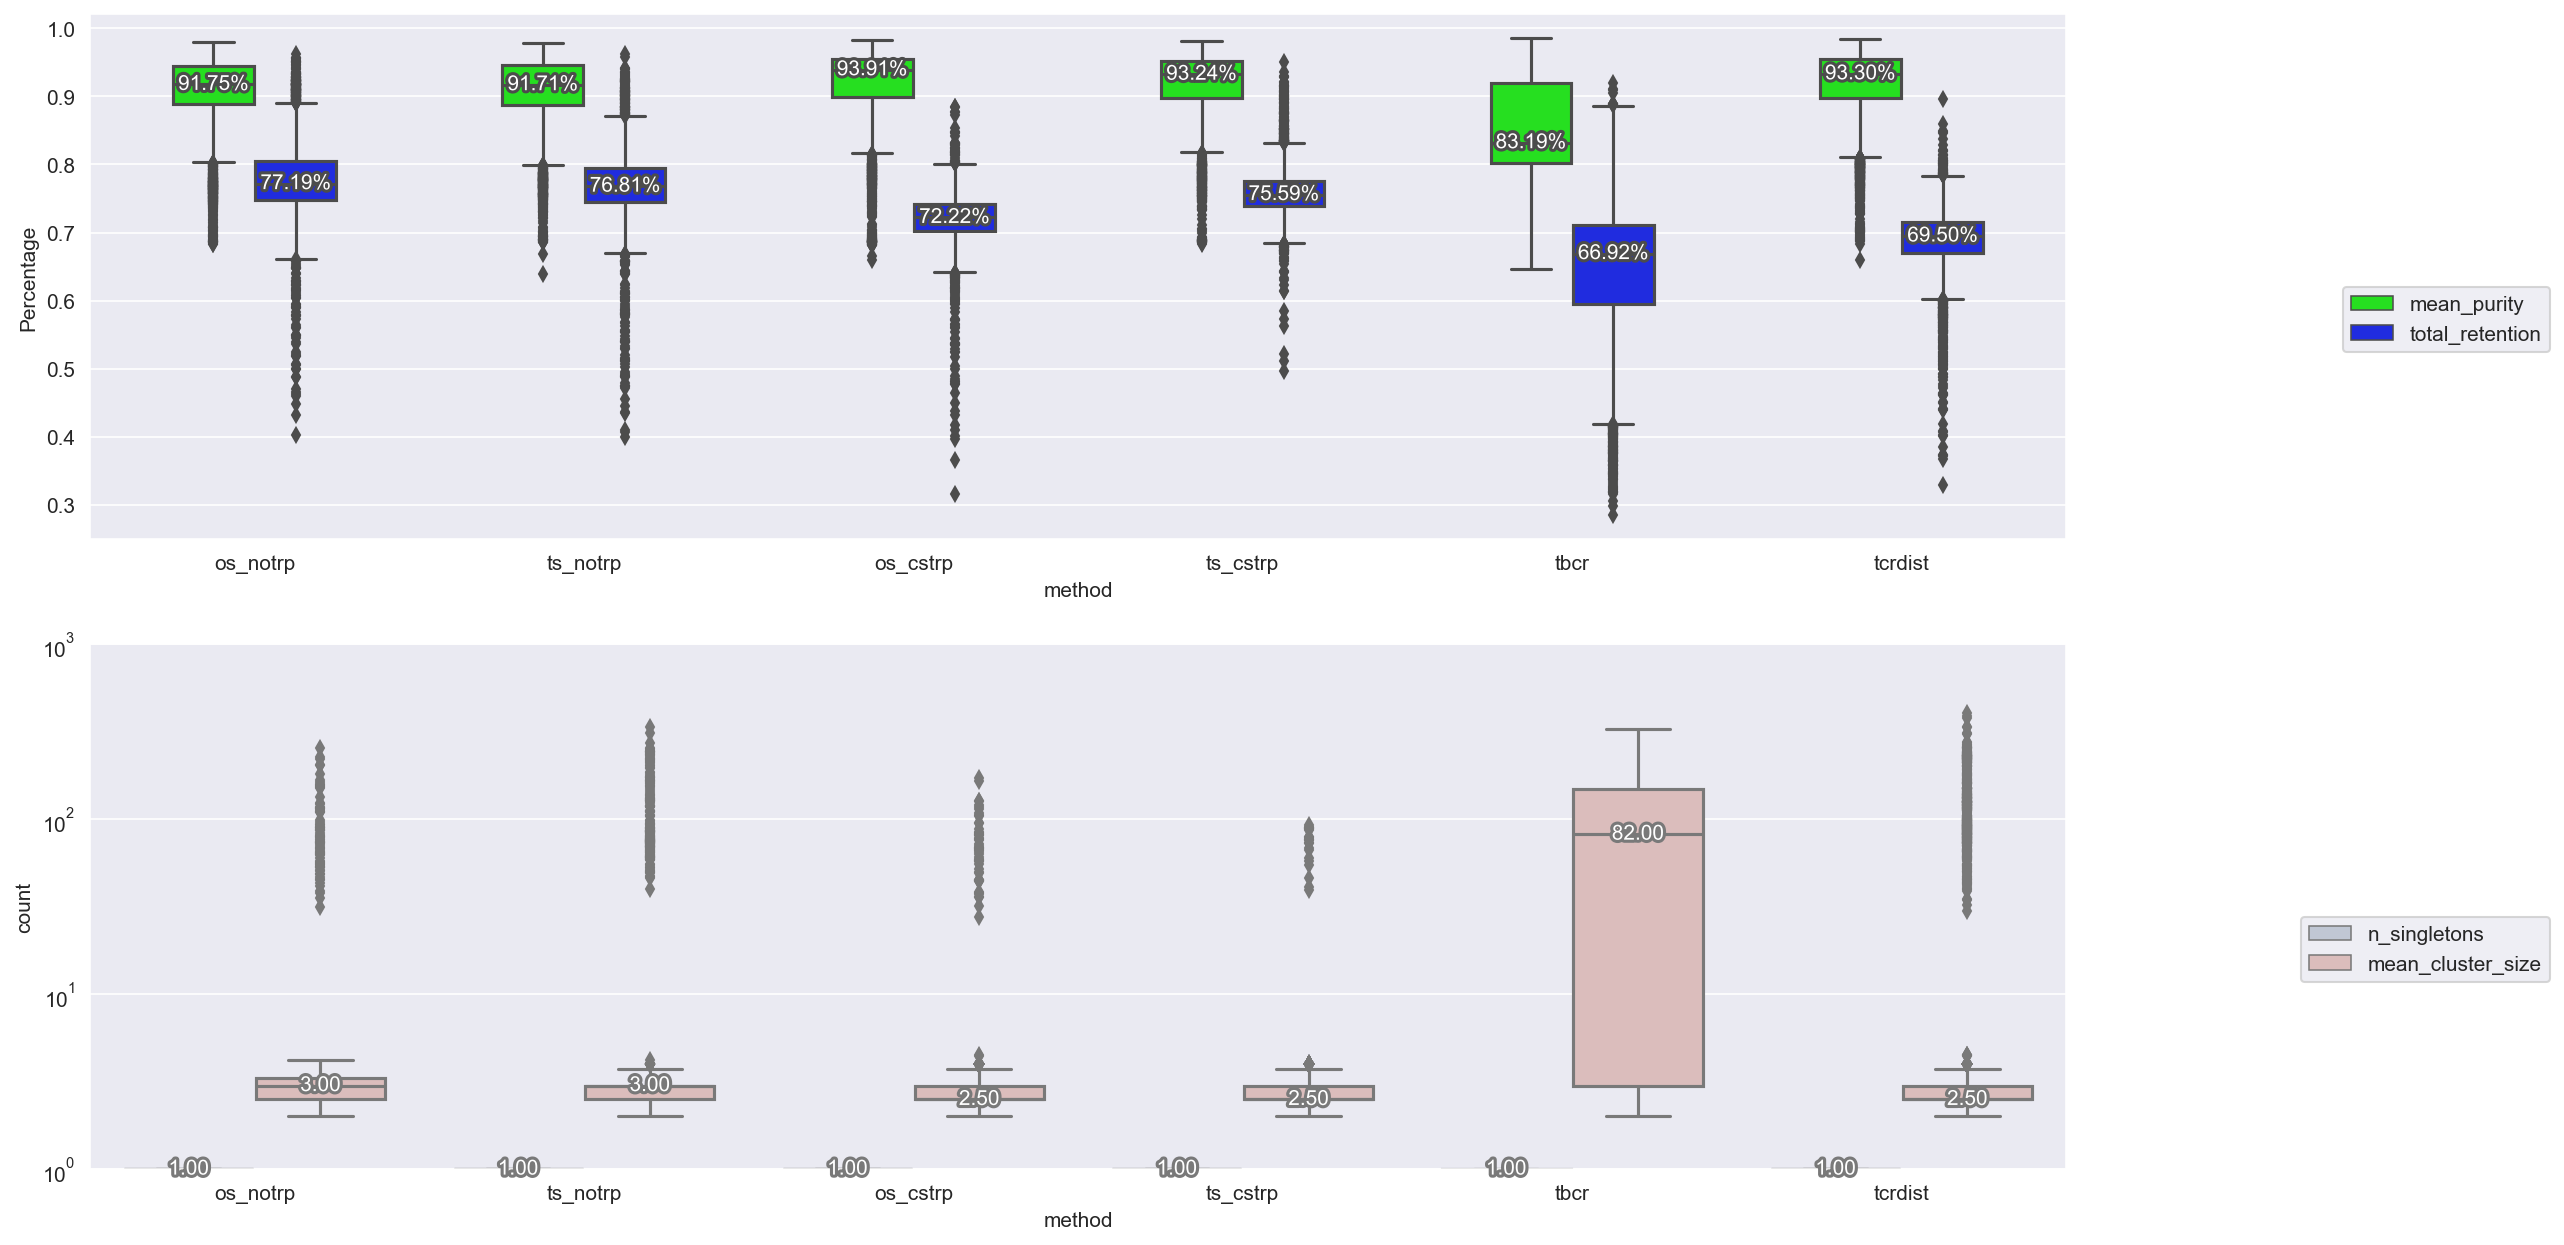

In [1651]:
from src.utils import add_median_labels
mpl.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots(2,1, figsize=(17, 10))
ax=ax.ravel()
first_ax=ax[0]
twin_ax=ax[1]
twin_ax.set_yscale('log')
twin_ax.set_ylim(1,1000)
# percentages = all_cat.melt(id_vars=['method','run'], value_vars = ['mean_purity','total_retention'])

# numbers = all_cat.melt(id_vars=['method','run'], value_vars = ['n_singletons', 'mean_cluster_size'])
percentages = all_cat.melt(id_vars=['method','run'], value_vars = ['mean_purity','total_retention'])
melt = all_cat.melt(id_vars=['method','run'], value_vars = ['mean_purity','total_retention', 'n_singletons', 'mean_cluster_size'])

sns.boxplot(percentages, x='method', y='value', hue='variable', ax=first_ax, width=0.5, palette='hsv',  dodge=True)
sns.boxplot(numbers, x='method', y='value', hue='variable', ax=twin_ax, width=0.8, palette='vlag')
add_median_labels(first_ax, fmt='.2%', fontsize=10, fontweight='normal')
add_median_labels(twin_ax, fmt='.2f', fontsize=10, fontweight='normal')
first_ax.set_ylabel('Percentage')
twin_ax.set_ylabel('count')
first_ax.legend(bbox_to_anchor=(1.25,.5))
twin_ax.legend(bbox_to_anchor=(1.25,.5))

In [1652]:
from scipy.stats import ttest_ind, pearsonr

In [1658]:
melt.head()

,method,run,variable,value
0,os_notrp,0,mean_purity,0.804100
1,os_notrp,0,mean_purity,0.878249
2,os_notrp,0,mean_purity,0.890625
3,os_notrp,0,mean_purity,0.898496
4,os_notrp,0,mean_purity,0.867910


In [1657]:
melt.query('method=="os_cstrp" and variable == "mean_retention"')['value'].dropna().values

array([], dtype=float64)

In [1673]:
def get_pv_rp(m_a='os_cstrp', m_b='tbcr'):
    pval_purity = ttest_ind(melt.query('method==@m_a and variable == "mean_purity"')['value'].dropna().values, 
          melt.query('method==@m_b and variable == "mean_purity"')['value'].dropna().values, equal_var=False, alternative='greater')
    pval_retention = ttest_ind(melt.query('method==@m_a and variable == "total_retention"')['value'].dropna().values, 
              melt.query('method==@m_b and variable == "total_retention"')['value'].dropna().values, equal_var=False, alternative='greater')
    print('Welch t-test')
    print(f'AvgMean purity : {m_a} > {m_b}: p<=', pval_purity[1].round(4))
    print(f'AvgTotal Retention: {m_a} > {m_b}: p<=', pval_retention[1].round(4))

In [1685]:
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
m = TwoStageCNNVAECLF(vae_kwargs={}, clf_kwargs={})

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()


In [1696]:
from src.torch_utils import load_json, load_model_full
def load_previous_run(args, device):
    if args['model_folder'] is not None:
        # model_folder
        # model_pt
        # model_json
        curves = list(filter(lambda x: 'loss' in x or 'metric' in x,
                             glob.glob(f"{args['model_folder']}/*.pkl")))
        # Reading old dict curves
        dict_curves = {}
        for k in ['train_losses', 'train_metrics', 'valid_losses', 'valid_metrics']:
            dict_curves[k] = pkl_load(next(filter(lambda x: k in x, curves)))
        run_params = load_json(glob.glob(f"{args['model_folder']}/*run_param*.json")[0])
        checkpoint_file = next(
            filter(lambda x: 'best' in x.lower() and 'checkpoint' in x and 'interval' not in x and 'last' not in x,
                   glob.glob(f'{args["model_folder"]}/*.pt')))
        checkpoint_file = checkpoint_file if args['model_pt'] is None else args['model_pt']
        model_json = next(filter(lambda x: 'checkpoint' in x,
                                 glob.glob(f'{args["model_folder"]}/*.json'))) if args['model_json'] is None else args[
            'model_json']
        try:
            model, model_params = load_model_full(checkpoint_file, model_json,
                                                  return_json=True, verbose=True,
                                                  return_best_dict=True, map_location=device)
        except:
            print(args['model_folder'], '\n', os.listdir(args['model_folder']))
            raise ValueError(f'\n\n\nCouldn\'t load your files!! at {args["model_folder"]}\n\n\n')
    else:
        model, model_params = load_model_full(args['pt_file'], args['json_file'],
                                              return_json=True, verbose=True,
                                              return_best_dict=True, map_location=device)
        dict_curves = None
    # update params to disable warmup KLD
    for k in run_params:
        if 'warm_up' in k:
            run_params[k] = 0
    best_dict = model_params.pop('best')
    filter_key = next(filter(lambda x: 'epoch' in x, best_dict.keys()))
    restart_epoch = best_dict[filter_key]
    # override device setting
    run_params['device'] = device
    run_params['restart_epoch'] = restart_epoch if 'last_epoch' not in checkpoint_file else run_params['n_epochs']
    # Extract the VAE part only if it's a two-stage:
    if hasattr(model, 'vae'):
        model = model.vae
    
    return model, model_params, run_params, dict_curves
    
args = {'model_folder':'../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/', 'model_pt':None, 'model_json':None}
model, model_params, run_params, dict_curves = load_previous_run(args, 'cpu')

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
Reloading best model:
Best epoch: 3501
total: 0.1996195324089216
reconstruction: 0.06153779213157151
kld: 0.0
triplet: 0.0
BCE: 0.13808174128219397
seq_accuracy: 0.9956761598587036
pos_accuracy: 0.9978764653205872
auc: 0.53272
auc_01: 0.50194
auc_01_real: 0.05368
precision: 0.18328
recall: 0.51096
accuracy: 0.5376
AP: 0.17974


In [1707]:
%ls ../output/240411_ClusteringTests/dist_matrices/

240422_new_df_filt_tcrdist3.csv
240422_new_df_tcrdist3.csv
240422_new_df_tcrdist3_labelled.csv
2404XX_OUTPUT_tbcralign_cdr3_distmatrix_140peps_labeled.csv
2404XX_OUTPUT_tbcralign_cdr3_distmatrix_26peps_labeled.csv
2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv
2404XX_OUTPUT_tbcralign_distmatrix_26peps_labeled.csv
OUTPUT_distmatrix_kernelsim_140peps_labelled.csv
OUTPUT_distmatrix_kernelsim_26peps_labelled.csv
OUTPUT_index_tcrs_140pep.txt
OUTPUT_index_tcrs_26pep.txt
OUTPUT_tbcralign_distmatrix_26peps.csv
readme
tcrdist3_cdr3_distmatrix_140peps_labeled.csv
tcrdist3_cdr3_distmatrix_26peps_labeled.csv
tcrdist3_distmatrix_140peps_new_labeled.csv
tcrdist3_distmatrix_26peps_old_labeled.csv
tcrdist3_old_26peps.pkl
tcrdist3_old_26peps_filter_top15peps.pkl
tcrdist3_old_26peps_labelled.csv


In [1713]:
%ls ../output/240411_ClusteringTests/dist_matrices/ | grep tcrdist

240422_new_df_filt_tcrdist3.csv
240422_new_df_tcrdist3.csv
240422_new_df_tcrdist3_labelled.csv
tcrdist3_cdr3_distmatrix_140peps_labeled.csv
tcrdist3_cdr3_distmatrix_26peps_labeled.csv
tcrdist3_distmatrix_140peps_new_labeled.csv
tcrdist3_distmatrix_26peps_old_labeled.csv
tcrdist3_old_26peps.pkl
tcrdist3_old_26peps_filter_top15peps.pkl
tcrdist3_old_26peps_labelled.csv


In [1715]:
tbcr_140 = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0)
tcrdist_140 = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/tcrdist3_distmatrix_140peps_new_labeled.csv', index_col=0)
tbcr_140.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,9725,9726,9727,9728,9729,9730,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741,9742,9743,9744,9745,9746,9747,9748,9749,9750,9751,9752,9753,9754,9755,9756,9757,9758,9759,9760,9761,9762,9763,9764,9765,9766,9767,9768,peptide,original_peptide,binder,partition,raw_index
q_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.183883,0.178238,0.173911,0.170075,0.187110,0.161335,0.157359,0.193784,0.150145,0.172535,0.211925,0.219707,0.229043,0.163260,0.147180,0.189735,0.160436,0.171463,0.158689,0.164467,0.177871,0.175746,0.161350,0.192655,0.167333,0.161243,0.164954,0.172736,0.187928,0.160374,0.189944,0.181623,0.200162,0.174122,0.186408,0.175657,0.156834,0.172134,0.182221,0.166851,0.165500,0.176601,0.177505,0.173403,0.168412,0.207530,0.179722,0.169385,...,0.181557,0.173104,0.184136,0.201847,0.169150,0.148286,0.159410,0.195799,0.157916,0.193314,0.192147,0.188628,0.193402,0.174650,0.163854,0.192871,0.163647,0.174112,0.158637,0.170202,0.181622,0.191477,0.161212,0.176034,0.158414,0.148103,0.181526,0.159228,0.199163,0.172669,0.177194,0.182653,0.163102,0.185979,0.142321,0.172775,0.185981,0.163420,0.164203,0.178030,0.204922,0.191003,0.153480,0.144758,TTDPSFLGRY,TTDPSFLGRY,1,1,VDJdb_69875
1,0.183883,0.000000,0.200009,0.162160,0.203413,0.211574,0.184512,0.192124,0.221551,0.173059,0.210426,0.248671,0.212747,0.241175,0.190527,0.206202,0.214996,0.179954,0.180538,0.184683,0.203862,0.212926,0.206039,0.213230,0.203029,0.186496,0.170095,0.210127,0.201746,0.218533,0.178446,0.234885,0.214284,0.206918,0.193217,0.189140,0.169527,0.163804,0.213433,0.222723,0.204120,0.198222,0.192653,0.197864,0.172978,0.205837,0.233119,0.182740,0.210701,...,0.172556,0.173062,0.216663,0.196642,0.206800,0.166724,0.171171,0.215147,0.186952,0.162207,0.197603,0.195422,0.205611,0.206700,0.210683,0.226799,0.182113,0.172034,0.221575,0.185712,0.209403,0.204814,0.205421,0.214019,0.172519,0.189729,0.162143,0.173686,0.197925,0.220433,0.205195,0.158062,0.194195,0.180352,0.197166,0.178733,0.209684,0.206792,0.184386,0.225295,0.209033,0.213252,0.181876,0.178095,RLPGVLPRA,RLPGVLPRA,1,4,VDJdb_73754
2,0.178238,0.200009,0.000000,0.214621,0.225911,0.219611,0.209837,0.209927,0.223482,0.193515,0.217910,0.208787,0.261883,0.236869,0.170163,0.208234,0.196441,0.209152,0.165401,0.179947,0.180706,0.199541,0.207313,0.231257,0.217244,0.200474,0.208734,0.201083,0.205212,0.200983,0.185133,0.237683,0.186382,0.229887,0.218799,0.182126,0.189794,0.211045,0.187387,0.226502,0.217918,0.203232,0.219582,0.193397,0.199266,0.176853,0.215660,0.197439,0.204667,...,0.213877,0.170482,0.200833,0.233133,0.213358,0.170483,0.185673,0.191673,0.185653,0.202165,0.228380,0.198119,0.212361,0.219943,0.187443,0.226102,0.223029,0.210554,0.195223,0.182991,0.197862,0.209683,0.216176,0.198737,0.204386,0.169719,0.222624,0.172604,0.189237,0.168618,0.201976,0.189967,0.199287,0.198713,0.159967,0.217799,0.171142,0.191158,0.193335,0.222728,0.219460,0.217663,0.191211,0.177059,LLDFVRFMGV,LLDFVRFMGV,1,4,ITRAP_4812
3,0.173911,0.162160,0.214621,0.000000,0.173506,0.185031,0.169649,0.140149,0.201128,0.165969,0.171762,0.223293,0.208068,0.230935,0.172791,0.166650,0.207207,0.186119,0.188202,0.192445,0.189802,0.200666,0.170183,0.186558,0.196853,0.204749,0.188240,0.184946,0.168263,0.195048,0.168973,0.187897,0.205965,0.183762,0.169702,0.174973,0.187068,0.172028,0.201632,0.214589,0.174243,0.181313,0.215447,0.178859,0.190782,0.175518,0.204372,0.186454,0.186081,...,0.179327,0.193065,0.213705,0.205779,0.169903,0.178610,0.154867,0.183279,0.202001,0.195982,0.172477,0.212406,0.174142,0.198994,0.169186,0.214006,0.178937,0.191106,0.200832,0.182867,0.232178,0.210301,0.154934,0.183214,0.172086,0.191913,0.192282,0.173589,0.218735,0.195789,0.181701,0.187861,0.198438,0.182997,0.187106,0.174421,0.203853,0.180622,0.169914,0.182952,0.221029,0.185741,0.179057,0.176

In [1716]:
tbcr_17 = tbcr_140.query('partition==1 and peptide in @top17peps')
tcrdist_17 = tcrdist_140.query('partition==1 and peptide in @top17peps')

In [1717]:
from src.cluster_utils import run_interval_clustering

In [1723]:
tbcr_17 = tbcr_17.loc[:, [str(x) for x in tbcr_17.index]+['peptide','partition','binder','raw_index','original_peptide']]
tcrdist_17 = tcrdist_17.loc[:, [str(x) for x in tbcr_17.index]+['peptide','partition','binder','raw_index','original_peptide']]

In [1727]:
from src.cluster_utils import cluster_all_thresholds, do_three_clustering, get

In [1729]:
def do_this_shit(dm):
    labels=dm['peptide'].values
    indices=dm['raw_index'].values
    label_encoder = LabelEncoder()
    encoded_labels = LabelEncoder.fit_transform(labels)
    

In [1728]:
get_distances_labels_from_distmatrix??

Signature:
get_distances_labels_from_distmatrix(
    dist_matrix,
    original_df,
    index_tcr_df,
    label_col='peptide',
    query_subset=None,
)
Docstring: <no docstring>
Source:   
def get_distances_labels_from_distmatrix(dist_matrix, original_df, index_tcr_df, label_col='peptide',
                                         query_subset=None):
    merged_dist_matrix, extra_cols = get_merged_distances_labels(dist_matrix, original_df, index_tcr_df, label_col,
                                                                 query_subset)
    dist_array = merged_dist_matrix.iloc[:, :-len(extra_cols)].values
    features = torch.randn([dist_array.shape[0], 3])
    label_encoder = LabelEncoder()
    labels = merged_dist_matrix[label_col].values
    encoded_labels = label_encoder.fit_transform(labels)
    return merged_dist_matrix, dist_array, features, labels, encoded_labels, label_encoder
File:      ~/Documents/code/tclustr/src/cluster_utils.py
Type:      function

In [1705]:
pd.read_csv('../output/240515_IntervalClustering/valid_baselines.csv').groupby(['input_type', 'db']).count()

Unnamed: 0  threshold  n_cluster  \
input_type db                                                      
TBCRalign  CDR3_ExpData17peps          500        500        500   
           CDR3_ExpDataTop78           500        500        500   
           CDR3_OldDataNoPrune         500        500        500   
           CDR3_OldDataTop15           500        500        500   
           CDR3_OldDataTop20           500        500        500   
           ExpData17peps               499        499        499   
           ExpDataTop78                500        500        500   
           OldDataNoPrune              499        499        499   
           OldDataTop15                500        500        500   
           OldDataTop20                499        499        499   
tcrdist3   CDR3_ExpData17peps          500        500        500   
           CDR3_ExpDataTop78           500        500        500   
           CDR3_OldDataNoPrune         500        500        500   
           CDR3_OldDataTop15           500        500        500   
           CDR3_OldDataTop20           500        500        500   
           ExpData17peps               499        499        499   
           ExpDataTop78                500        500        500   
           OldDataNoPrune              499        499        499   
           OldDataTop15                500        500        500   
           OldDataTop20                499        499        499   

                                n_singletons  n_cluster_over_70p  mean_purity  \
input_type db                                                                   
TBCRalign  CDR3_ExpData17peps            500                 500          499   
           CDR3_ExpDataTop78             500                 500          499   
           CDR3_OldDataNoPrune           500                 500          499   
           CDR3_OldDataTop15             500                 500          499   
           CDR3_OldDataTop20             500                 500          499   
           ExpData17peps                 499                 499          499   
           ExpDataTop78                  500                 500          499   
           OldDataNoPrune                499                 499          499   
           OldDataTop15                  500                 500          499   
           OldDataTop20                  499                 499          499   
tcrdist3   CDR3_ExpData17peps            500                 500          499   
           CDR3_ExpDataTop78             500                 500          499   
           CDR3_OldDataNoPrune           500                 500          499   
           CDR3_OldDataTop15             500                 500          499   
           CDR3_OldDataTop20             500                 500          499   
           ExpData17peps                 499                 499          499   
           ExpDataTop78                  500                 500          499   
           OldDataNoPrune                499                 499          499   
           OldDataTop15                  500                 500          499   
           OldDataTop20                  499                 499          499   

                                min_purity  max_purity  mean_coherence  \
input_type db                                                            
TBCRalign  CDR3_ExpData17peps          499         499             499   
           CDR3_ExpDataTop78           499         499             499   
           CDR3_OldDataNoPrune         499         499             499   
           CDR3_OldDataTop15           499         499             499   
           CDR3_OldDataTop20           499         499             499   
           ExpData17peps               499         499             499   
           ExpDataTop78                499         499             499   
           OldDataNoPrune              499         499             499   
           O

In [1703]:
newdf.groupby('peptide').agg(count=('B3','count')).sort_values('count', ascending=False).head(10)

,count
peptide,
GILGFVFTL,6990
KLGGALQAK,5406
RAKFKQLL,4980
AVFDRKSDAK,4302
ELAGIGILTV,2742
SPRWYFYYL,2694
YLQPRTFLL,2394
TTDPSFLGRY,2322
LLWNGPMAV,2226


In [1698]:
run_params

{'cuda': True,
 'device': 'cpu',
 'log_wandb': False,
 'file': '/home/projects/vaccine/people/yatwan/tclustr/data/filtered/240618_nettcr_exp_nested_swap_train_p0234.csv',
 'test_file': '/home/projects/vaccine/people/yatwan/tclustr/data/filtered/240618_nettcr_exp_nested_swap_test_p1.csv',
 'out': 'Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData',
 'outdir': '240618_NestedKCV_CNNVAE',
 'a1_col': 'A1',
 'a2_col': 'A2',
 'a3_col': 'A3',
 'b1_col': 'B1',
 'b2_col': 'B2',
 'b3_col': 'B3',
 'max_len_a1': 7,
 'max_len_a2': 8,
 'max_len_a3': 22,
 'max_len_b1': 6,
 'max_len_b2': 7,
 'max_len_b3': 23,
 'max_len_pep': 0,
 'encoding': 'BL50LO',
 'pad_scale': -20.0,
 'pep_dim': 12,
 'add_positional_encoding': True,
 'positional_weighting': True,
 'minority_sampler': True,
 'minority_count': 50,
 'kernel_size_in': 9,
 'stride_in': 4,
 'pad_in': 2,
 'kernel_size_trans': 9,
 'stride_trans': 4,
 'pad_trans': 2,
 'output_padding_trans_1': 1,
 'output_padding_trans_2': 0,
 'hidden_dim': 128,
 'latent_di

In [1687]:
hasattr(m, 'aae')

True

In [1681]:
get_pv_rp('os_cstrp', 'tcrdist')

Welch t-test
AvgMean purity : os_cstrp > tcrdist: p<= 0.0059
AvgTotal Retention: os_cstrp > tcrdist: p<= 0.0


In [1386]:
newdf = pd.read_csv('../data/filtered/240326_nettcr_paired_withswaps.csv')
newdf.query('peptide in ["ELAGIGILTV", "GILGFVFTL", "RAKFKQLL", "YLQPRTFLL", "GLCTLVAML", "LLWNGPMAV", "GLCTLVAML"]').reset_index(drop=True).to_csv('../data/240905_nettcr_exp_paired_easy7peps_withswaps.txt', index=False)
newdf.query('binder==1 and peptide in ["ELAGIGILTV", "GILGFVFTL", "RAKFKQLL", "YLQPRTFLL", "GLCTLVAML", "LLWNGPMAV", "GLCTLVAML"]').reset_index(drop=True).to_csv('../data/240905_nettcr_exp_paired_easy7peps_binders_only.txt', index=False)
